In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import random
import matplotlib.pyplot as plt
import itertools
import os
from tqdm import tqdm
import gc

# Rastgeleliği Sabitleme (Tekrar üretilebilir sonuçlar için)
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("✅ Kütüphaneler yüklendi ve seed ayarlandı.")

✅ Kütüphaneler yüklendi ve seed ayarlandı.


In [2]:
# ====================================================
# 2️⃣ Cihaz ve GPU Kontrolü
# ====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\n" + "="*60)
print("🖥️  CİHAZ BİLGİLERİ")
print("="*60)
print(f"Kullanılacak cihaz: {device}")

if torch.cuda.is_available():
    print(f"✅ GPU KULLANILIYOR!")
    print(f"   GPU Adı: {torch.cuda.get_device_name(0)}")
    print(f"   Toplam GPU Belleği: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    
    # Mevcut belleği kontrol et
    torch.cuda.empty_cache()
    print(f"   Kullanılabilir Bellek: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / 1024**3:.2f} GB")
else:
    print("⚠️  GPU BULUNAMADI - CPU kullanılıyor (eğitim çok yavaş olacak!)")
    print("   GPU kullanmak için CUDA yüklü olmalı.")

print("="*60)


🖥️  CİHAZ BİLGİLERİ
Kullanılacak cihaz: cuda
✅ GPU KULLANILIYOR!
   GPU Adı: NVIDIA GeForce RTX 4060 Laptop GPU
   Toplam GPU Belleği: 8.00 GB
   Kullanılabilir Bellek: 8.00 GB


In [3]:
# ====================================================
# 3️⃣ Veri Dönüşümleri ve Dataset Yükleme
# ====================================================
print("\n📁 Veri seti yükleniyor...")

# Veri dönüşümleri (224x224 - orjinal gereksinime uygun)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ⚠️ DİKKAT: Kendi veri yolunuzu buraya yazın!
DATA_DIR = r'C:\Users\user\Desktop\DerinProjem\garbage-dataset'

try:
    dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
    print(f"✅ Veri seti başarıyla yüklendi!")
    print(f"   Toplam örnek sayısı: {len(dataset)}")
except FileNotFoundError:
    print(f"❌ HATA: Veri seti bulunamadı!")
    print(f"   Aranan yol: {DATA_DIR}")
    print(f"   Lütfen DATA_DIR değişkenini kontrol edin.")
    exit()

class_names = dataset.classes
print(f"   Sınıflar: {class_names}")
NUM_CLASSES = len(class_names)
print(f"   Toplam sınıf sayısı: {NUM_CLASSES}")


📁 Veri seti yükleniyor...
✅ Veri seti başarıyla yüklendi!
   Toplam örnek sayısı: 19762
   Sınıflar: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
   Toplam sınıf sayısı: 10


In [4]:
# ====================================================
# 4️⃣ Train / Val / Test Split
# ====================================================
print("\n📊 Veri seti bölünüyor...")

# BATCH_SIZE - GPU bellek hatası önlemek için 16'ya düşürüldü
BATCH_SIZE = 32  
print(f"   Batch Size: {BATCH_SIZE}")

targets = [s[1] for s in dataset.samples]

# Train ve Geçici (Val+Test) Olarak Bölme
train_idx, temp_idx = train_test_split(
    range(len(dataset)), test_size=0.3, stratify=targets, random_state=42
)

temp_targets = [targets[i] for i in temp_idx]

# Geçici Kümeyi Val ve Test Olarak Bölme
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=temp_targets, random_state=42
)

# DataLoader'ları Oluşturma
train_loader = DataLoader(
    Subset(dataset, train_idx), 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0,  # Windows için önerilen
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    Subset(dataset, val_idx), 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    Subset(dataset, test_idx), 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"✅ Veri bölme tamamlandı!")
print(f"   Eğitim: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")


📊 Veri seti bölünüyor...
   Batch Size: 32
✅ Veri bölme tamamlandı!
   Eğitim: 13833, Val: 2964, Test: 2965


In [5]:
# ====================================================
# 5️⃣ 4 Katmanlı MLP Modeli (Bellek Optimizasyonlu)
# ====================================================
print("\n🧠 Model tanımlanıyor...")

class ShallowMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ShallowMLP, self).__init__()
        # Orjinal tasarım: 4 katman
        # Ancak bellek hatası önlemek için katman boyutları küçültüldü
        
        self.layers = nn.Sequential(
            nn.Flatten(),  # Görüntüyü vektöre düzleştir
            
            # 1. Gizli Katman (2048)
            nn.Linear(input_size, 2048),
            nn.ReLU(),
            nn.Dropout(0.3),  # Overfitting önleme
            
            # 2. Gizli Katman
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # 3. Gizli Katman
            nn.Linear(512, 128),
            nn.ReLU(),
            
            # Çıkış Katmanı
            nn.Linear(128, num_classes)
        )
    
    # ✅ DÜZELTME: forward metodu doğru şekilde sınıfın içine hizalandı
    def forward(self, x):
        return self.layers(x)

INPUT_SIZE = 224 * 224 * 3  # 150528
print(f"✅ Model tanımlandı!")
print(f"   Giriş boyutu: {INPUT_SIZE}")
print(f"   Çıkış (sınıf sayısı): {NUM_CLASSES}")
print(f"   Mimari: {INPUT_SIZE} -> 2048 -> 512 -> 128 -> {NUM_CLASSES}")


🧠 Model tanımlanıyor...
✅ Model tanımlandı!
   Giriş boyutu: 150528
   Çıkış (sınıf sayısı): 10
   Mimari: 150528 -> 2048 -> 512 -> 128 -> 10


In [6]:
# ====================================================
# 6️⃣ Random Search: Öğrenme Oranı Seçimi 🔎
# ====================================================
print("\n🔍 Random Search başlatılıyor (LR optimizasyonu)...")

# Logaritmik olarak dağılmış 5 aday LR (10^-5 ile 10^-2 arası)
log_min = np.log10(1e-5)
log_max = np.log10(1e-2)
lr_candidates = 10**np.random.uniform(log_min, log_max, 5)

random_epochs = 5  # Her aday için 5 epoch
patience = 3       # Erken durdurma sabrı

best_lr = 0.0
best_val_acc = -1.0
temp_weights_file = 'temp_best_lr_weights.pth'

print(f"   Aday LR'ler: {[f'{lr:.8f}' for lr in lr_candidates]}")
print(f"   Her aday için epoch sayısı: {random_epochs}")
print(f"   Erken durdurma patience: {patience}")

for i, lr_candidate in enumerate(lr_candidates):
    print(f"\n{'='*60}")
    print(f"[Deneme {i+1}/{len(lr_candidates)}: LR = {lr_candidate:.8f}]")
    print(f"{'='*60}")
    
    # Belleği temizle
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
    
    # Model oluştur
    model = ShallowMLP(INPUT_SIZE, NUM_CLASSES).to(device)
    optim_adam = optim.Adam(model.parameters(), lr=lr_candidate)
    criterion = nn.CrossEntropyLoss()
    scheduler = CosineAnnealingLR(optim_adam, T_max=random_epochs)
    
    current_best_val_acc = -1.0
    epochs_no_improve = 0
    
    for epoch in range(1, random_epochs + 1):
        # ============ EĞİTİM ADIMI ============
        model.train()
        train_loss = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optim_adam.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optim_adam.step()
            
            train_loss += loss.item()
        
        # ============ DOĞRULAMA ADIMI ============
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = correct / total
        avg_train_loss = train_loss / len(train_loader)
        
        print(f"  Epoch {epoch}/{random_epochs} - Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        scheduler.step()
        
        # ============ ERKEN DURDURMA VE AĞIRLIK KAYDI ============
        if val_acc > current_best_val_acc:
            current_best_val_acc = val_acc
            epochs_no_improve = 0
            
            # Global en iyi ise kaydet
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_lr = lr_candidate
                torch.save(model.state_dict(), temp_weights_file)
                print(f"    ⭐ YENİ EN İYİ VAL ACC! Ağırlıklar kaydedildi.")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"    ⚠️  Erken Durdurma: {patience} epoch boyunca iyileşme yok.")
                break
    
    # Modeli sil (bellek temizliği)
    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"\n{'='*60}")
print(f"🎯 RANDOM SEARCH SONUCU")
print(f"{'='*60}")
print(f"En İyi Öğrenme Oranı (Best LR): {best_lr:.8f}")
print(f"En İyi Doğrulama Doğruluğu: {best_val_acc:.4f}")
print(f"{'='*60}")


🔍 Random Search başlatılıyor (LR optimizasyonu)...
   Aday LR'ler: ['0.00013293', '0.00711448', '0.00157030', '0.00062514', '0.00002938']
   Her aday için epoch sayısı: 5
   Erken durdurma patience: 3

[Deneme 1/5: LR = 0.00013293]
  Epoch 1/5 - Loss: 2.2625, Val Acc: 0.3890
    ⭐ YENİ EN İYİ VAL ACC! Ağırlıklar kaydedildi.
  Epoch 2/5 - Loss: 1.7308, Val Acc: 0.4200
    ⭐ YENİ EN İYİ VAL ACC! Ağırlıklar kaydedildi.
  Epoch 3/5 - Loss: 1.5729, Val Acc: 0.4656
    ⭐ YENİ EN İYİ VAL ACC! Ağırlıklar kaydedildi.
  Epoch 4/5 - Loss: 1.4573, Val Acc: 0.5061
    ⭐ YENİ EN İYİ VAL ACC! Ağırlıklar kaydedildi.
  Epoch 5/5 - Loss: 1.3312, Val Acc: 0.5273
    ⭐ YENİ EN İYİ VAL ACC! Ağırlıklar kaydedildi.

[Deneme 2/5: LR = 0.00711448]
  Epoch 1/5 - Loss: 20.8146, Val Acc: 0.2696
  Epoch 2/5 - Loss: 2.3296, Val Acc: 0.2696
  Epoch 3/5 - Loss: 2.2135, Val Acc: 0.2696
  Epoch 4/5 - Loss: 2.1295, Val Acc: 0.2696
    ⚠️  Erken Durdurma: 3 epoch boyunca iyileşme yok.

[Deneme 3/5: LR = 0.00157030]
  Ep

In [7]:
# ====================================================
# 7️⃣ Tam Eğitim (En İyi LR ile) 🚀
# ====================================================
print(f"\n🚀 TAM EĞİTİM BAŞLIYOR!")
print(f"   Kullanılacak LR: {best_lr:.8f}")

final_epochs = 30  # Tam eğitim için epoch sayısı
patience_final = 5
final_weights_file = 'best_final_model.pth'

# Belleği temizle
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

# Model oluştur
final_model = ShallowMLP(INPUT_SIZE, NUM_CLASSES).to(device)
final_optim = optim.Adam(final_model.parameters(), lr=best_lr)
final_criterion = nn.CrossEntropyLoss()
final_scheduler = CosineAnnealingLR(final_optim, T_max=final_epochs)

best_final_val_acc = -1.0
epochs_no_improve_final = 0

print(f"   Toplam epoch: {final_epochs}")
print(f"   Erken durdurma patience: {patience_final}")
print(f"\nEğitim başlıyor...\n")

for epoch in range(1, final_epochs + 1):
    # ============ EĞİTİM ADIMI ============
    final_model.train()
    total_train_loss = 0
    train_correct = 0
    train_total = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{final_epochs}")
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        final_optim.zero_grad()
        outputs = final_model(images)
        loss = final_criterion(outputs, labels)
        loss.backward()
        final_optim.step()
        
        total_train_loss += loss.item() * images.size(0)
        
        # Eğitim doğruluğu
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # Progress bar güncelle
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * train_correct / train_total:.2f}%'
        })
    
    train_acc = train_correct / train_total
    avg_train_loss = total_train_loss / len(train_idx)
    
    # ============ DOĞRULAMA ADIMI ============
    final_model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = final_model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_acc = val_correct / val_total
    
    print(f"\n📊 Epoch {epoch}/{final_epochs} Özeti:")
    print(f"   Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"   Val Acc: {val_acc:.4f}")
    
    final_scheduler.step()
    
    # ============ ERKEN DURDURMA VE AĞIRLIK KAYDI ============
    if val_acc > best_final_val_acc:
        best_final_val_acc = val_acc
        epochs_no_improve_final = 0
        torch.save(final_model.state_dict(), final_weights_file)
        print(f"   ⭐ YENİ EN İYİ MODEL! Ağırlıklar '{final_weights_file}' dosyasına kaydedildi.")
    else:
        epochs_no_improve_final += 1
        print(f"   ⏳ İyileşme yok ({epochs_no_improve_final}/{patience_final})")
        
        if epochs_no_improve_final >= patience_final:
            print(f"\n⚠️  ERKEN DURDURMA: {patience_final} epoch boyunca iyileşme olmadı.")
            print(f"   Eğitim {epoch}. epoch'ta sonlandırıldı.")
            break
    
    print()  # Boş satır

# ============ EN İYİ AĞIRLIKLARI YÜKLE ============
if os.path.exists(final_weights_file):
    final_model.load_state_dict(torch.load(final_weights_file))
    print(f"\n✅ EN İYİ AĞIRLIKLAR YÜKLENDİ!")
    print(f"   En iyi Val Accuracy: {best_final_val_acc:.4f}")
else:
    print(f"\n⚠️  Uyarı: '{final_weights_file}' dosyası bulunamadı!")


🚀 TAM EĞİTİM BAŞLIYOR!
   Kullanılacak LR: 0.00002938
   Toplam epoch: 30
   Erken durdurma patience: 5

Eğitim başlıyor...



Epoch 1/30: 100%|███████████████████████████████████████████| 433/433 [18:05<00:00,  2.51s/it, loss=1.5761, acc=37.56%]



📊 Epoch 1/30 Özeti:
   Train Loss: 1.9035 | Train Acc: 0.3756
   Val Acc: 0.4362
   ⭐ YENİ EN İYİ MODEL! Ağırlıklar 'best_final_model.pth' dosyasına kaydedildi.



Epoch 2/30: 100%|███████████████████████████████████████████| 433/433 [18:13<00:00,  2.53s/it, loss=1.8020, acc=43.48%]



📊 Epoch 2/30 Özeti:
   Train Loss: 1.6629 | Train Acc: 0.4348
   Val Acc: 0.4649
   ⭐ YENİ EN İYİ MODEL! Ağırlıklar 'best_final_model.pth' dosyasına kaydedildi.



Epoch 3/30: 100%|███████████████████████████████████████████| 433/433 [18:05<00:00,  2.51s/it, loss=1.4842, acc=46.65%]



📊 Epoch 3/30 Özeti:
   Train Loss: 1.5610 | Train Acc: 0.4665
   Val Acc: 0.4875
   ⭐ YENİ EN İYİ MODEL! Ağırlıklar 'best_final_model.pth' dosyasına kaydedildi.



Epoch 4/30: 100%|███████████████████████████████████████████| 433/433 [18:55<00:00,  2.62s/it, loss=1.9570, acc=48.44%]



📊 Epoch 4/30 Özeti:
   Train Loss: 1.4810 | Train Acc: 0.4844
   Val Acc: 0.5233
   ⭐ YENİ EN İYİ MODEL! Ağırlıklar 'best_final_model.pth' dosyasına kaydedildi.



Epoch 5/30: 100%|███████████████████████████████████████████| 433/433 [17:31<00:00,  2.43s/it, loss=0.8808, acc=51.46%]



📊 Epoch 5/30 Özeti:
   Train Loss: 1.4147 | Train Acc: 0.5146
   Val Acc: 0.5327
   ⭐ YENİ EN İYİ MODEL! Ağırlıklar 'best_final_model.pth' dosyasına kaydedildi.



Epoch 6/30: 100%|███████████████████████████████████████████| 433/433 [17:52<00:00,  2.48s/it, loss=1.0390, acc=53.53%]



📊 Epoch 6/30 Özeti:
   Train Loss: 1.3477 | Train Acc: 0.5353
   Val Acc: 0.5250
   ⏳ İyileşme yok (1/5)



Epoch 7/30: 100%|███████████████████████████████████████████| 433/433 [17:57<00:00,  2.49s/it, loss=1.1308, acc=55.40%]



📊 Epoch 7/30 Özeti:
   Train Loss: 1.3054 | Train Acc: 0.5540
   Val Acc: 0.5570
   ⭐ YENİ EN İYİ MODEL! Ağırlıklar 'best_final_model.pth' dosyasına kaydedildi.



Epoch 8/30: 100%|███████████████████████████████████████████| 433/433 [17:54<00:00,  2.48s/it, loss=1.6817, acc=56.64%]



📊 Epoch 8/30 Özeti:
   Train Loss: 1.2511 | Train Acc: 0.5664
   Val Acc: 0.5401
   ⏳ İyileşme yok (1/5)



Epoch 9/30: 100%|███████████████████████████████████████████| 433/433 [17:35<00:00,  2.44s/it, loss=1.0854, acc=58.46%]



📊 Epoch 9/30 Özeti:
   Train Loss: 1.1963 | Train Acc: 0.5846
   Val Acc: 0.5628
   ⭐ YENİ EN İYİ MODEL! Ağırlıklar 'best_final_model.pth' dosyasına kaydedildi.



Epoch 10/30: 100%|██████████████████████████████████████████| 433/433 [17:49<00:00,  2.47s/it, loss=1.1697, acc=59.78%]



📊 Epoch 10/30 Özeti:
   Train Loss: 1.1631 | Train Acc: 0.5978
   Val Acc: 0.5644
   ⭐ YENİ EN İYİ MODEL! Ağırlıklar 'best_final_model.pth' dosyasına kaydedildi.



Epoch 11/30: 100%|██████████████████████████████████████████| 433/433 [17:33<00:00,  2.43s/it, loss=1.1770, acc=61.58%]



📊 Epoch 11/30 Özeti:
   Train Loss: 1.1098 | Train Acc: 0.6158
   Val Acc: 0.5911
   ⭐ YENİ EN İYİ MODEL! Ağırlıklar 'best_final_model.pth' dosyasına kaydedildi.



Epoch 12/30: 100%|██████████████████████████████████████████| 433/433 [17:34<00:00,  2.44s/it, loss=1.3058, acc=63.56%]



📊 Epoch 12/30 Özeti:
   Train Loss: 1.0646 | Train Acc: 0.6356
   Val Acc: 0.5935
   ⭐ YENİ EN İYİ MODEL! Ağırlıklar 'best_final_model.pth' dosyasına kaydedildi.



Epoch 13/30: 100%|██████████████████████████████████████████| 433/433 [17:31<00:00,  2.43s/it, loss=1.0419, acc=64.41%]



📊 Epoch 13/30 Özeti:
   Train Loss: 1.0261 | Train Acc: 0.6441
   Val Acc: 0.5864
   ⏳ İyileşme yok (1/5)



Epoch 14/30: 100%|██████████████████████████████████████████| 433/433 [17:53<00:00,  2.48s/it, loss=1.5033, acc=66.25%]



📊 Epoch 14/30 Özeti:
   Train Loss: 0.9790 | Train Acc: 0.6625
   Val Acc: 0.6036
   ⭐ YENİ EN İYİ MODEL! Ağırlıklar 'best_final_model.pth' dosyasına kaydedildi.



Epoch 15/30: 100%|██████████████████████████████████████████| 433/433 [17:34<00:00,  2.44s/it, loss=0.8133, acc=67.87%]



📊 Epoch 15/30 Özeti:
   Train Loss: 0.9278 | Train Acc: 0.6787
   Val Acc: 0.6039
   ⭐ YENİ EN İYİ MODEL! Ağırlıklar 'best_final_model.pth' dosyasına kaydedildi.



Epoch 16/30: 100%|██████████████████████████████████████████| 433/433 [17:40<00:00,  2.45s/it, loss=0.9678, acc=69.12%]



📊 Epoch 16/30 Özeti:
   Train Loss: 0.9039 | Train Acc: 0.6912
   Val Acc: 0.6117
   ⭐ YENİ EN İYİ MODEL! Ağırlıklar 'best_final_model.pth' dosyasına kaydedildi.



Epoch 17/30: 100%|██████████████████████████████████████████| 433/433 [17:31<00:00,  2.43s/it, loss=0.6427, acc=70.82%]



📊 Epoch 17/30 Özeti:
   Train Loss: 0.8564 | Train Acc: 0.7082
   Val Acc: 0.6120
   ⭐ YENİ EN İYİ MODEL! Ağırlıklar 'best_final_model.pth' dosyasına kaydedildi.



Epoch 18/30: 100%|██████████████████████████████████████████| 433/433 [17:29<00:00,  2.42s/it, loss=0.4464, acc=71.99%]



📊 Epoch 18/30 Özeti:
   Train Loss: 0.8165 | Train Acc: 0.7199
   Val Acc: 0.6218
   ⭐ YENİ EN İYİ MODEL! Ağırlıklar 'best_final_model.pth' dosyasına kaydedildi.



Epoch 19/30: 100%|██████████████████████████████████████████| 433/433 [17:31<00:00,  2.43s/it, loss=0.5815, acc=73.09%]



📊 Epoch 19/30 Özeti:
   Train Loss: 0.7890 | Train Acc: 0.7309
   Val Acc: 0.6215
   ⏳ İyileşme yok (1/5)



Epoch 20/30: 100%|██████████████████████████████████████████| 433/433 [17:54<00:00,  2.48s/it, loss=0.5400, acc=74.18%]



📊 Epoch 20/30 Özeti:
   Train Loss: 0.7481 | Train Acc: 0.7418
   Val Acc: 0.6248
   ⭐ YENİ EN İYİ MODEL! Ağırlıklar 'best_final_model.pth' dosyasına kaydedildi.



Epoch 21/30: 100%|██████████████████████████████████████████| 433/433 [17:26<00:00,  2.42s/it, loss=0.9054, acc=75.35%]



📊 Epoch 21/30 Özeti:
   Train Loss: 0.7166 | Train Acc: 0.7535
   Val Acc: 0.6377
   ⭐ YENİ EN İYİ MODEL! Ağırlıklar 'best_final_model.pth' dosyasına kaydedildi.



Epoch 22/30: 100%|██████████████████████████████████████████| 433/433 [17:34<00:00,  2.44s/it, loss=0.9914, acc=76.38%]



📊 Epoch 22/30 Özeti:
   Train Loss: 0.6860 | Train Acc: 0.7638
   Val Acc: 0.6377
   ⏳ İyileşme yok (1/5)



Epoch 23/30: 100%|██████████████████████████████████████████| 433/433 [17:56<00:00,  2.49s/it, loss=0.4519, acc=78.00%]



📊 Epoch 23/30 Özeti:
   Train Loss: 0.6584 | Train Acc: 0.7800
   Val Acc: 0.6410
   ⭐ YENİ EN İYİ MODEL! Ağırlıklar 'best_final_model.pth' dosyasına kaydedildi.



Epoch 24/30: 100%|██████████████████████████████████████████| 433/433 [17:52<00:00,  2.48s/it, loss=0.4925, acc=78.32%]



📊 Epoch 24/30 Özeti:
   Train Loss: 0.6452 | Train Acc: 0.7832
   Val Acc: 0.6427
   ⭐ YENİ EN İYİ MODEL! Ağırlıklar 'best_final_model.pth' dosyasına kaydedildi.



Epoch 25/30: 100%|██████████████████████████████████████████| 433/433 [17:58<00:00,  2.49s/it, loss=0.5970, acc=78.89%]



📊 Epoch 25/30 Özeti:
   Train Loss: 0.6285 | Train Acc: 0.7889
   Val Acc: 0.6417
   ⏳ İyileşme yok (1/5)



Epoch 26/30: 100%|██████████████████████████████████████████| 433/433 [17:28<00:00,  2.42s/it, loss=0.7248, acc=80.05%]



📊 Epoch 26/30 Özeti:
   Train Loss: 0.6017 | Train Acc: 0.8005
   Val Acc: 0.6474
   ⭐ YENİ EN İYİ MODEL! Ağırlıklar 'best_final_model.pth' dosyasına kaydedildi.



Epoch 27/30: 100%|██████████████████████████████████████████| 433/433 [17:39<00:00,  2.45s/it, loss=0.6594, acc=79.72%]



📊 Epoch 27/30 Özeti:
   Train Loss: 0.6033 | Train Acc: 0.7972
   Val Acc: 0.6471
   ⏳ İyileşme yok (1/5)



Epoch 28/30: 100%|██████████████████████████████████████████| 433/433 [17:39<00:00,  2.45s/it, loss=0.2936, acc=79.71%]



📊 Epoch 28/30 Özeti:
   Train Loss: 0.6003 | Train Acc: 0.7971
   Val Acc: 0.6447
   ⏳ İyileşme yok (2/5)



Epoch 29/30: 100%|██████████████████████████████████████████| 433/433 [17:55<00:00,  2.48s/it, loss=0.3817, acc=80.63%]



📊 Epoch 29/30 Özeti:
   Train Loss: 0.5823 | Train Acc: 0.8063
   Val Acc: 0.6471
   ⏳ İyileşme yok (3/5)



Epoch 30/30: 100%|██████████████████████████████████████████| 433/433 [17:57<00:00,  2.49s/it, loss=0.2519, acc=80.35%]



📊 Epoch 30/30 Özeti:
   Train Loss: 0.5862 | Train Acc: 0.8035
   Val Acc: 0.6471
   ⏳ İyileşme yok (4/5)



C:\Users\user\AppData\Local\Temp\ipykernel_35132\4088711875.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load(final_weights_file))


✅ EN İYİ AĞIRLIKLAR YÜKLENDİ!
   En iyi Val Accuracy: 0.6474


In [8]:
# ====================================================
# 📊 ADIM 7.5: GÜVENLİ ANALİZ (Hiçbir Şeyi Bozmaz!)
# ====================================================
print("\n" + "="*70)
print("✅ ADIM 7 TAMAMLANDI - ŞİMDİ ANALİZ YAPIYORUZ")
print("="*70)
print("⚠️  DİKKAT: Bu kod sadece analiz yapar, hiçbir şeyi bozmaz!")
print("="*70)

# Kontrol: Model dosyası var mı?
import os
if not os.path.exists('best_final_model.pth'):
    print("❌ HATA: 'best_final_model.pth' dosyası bulunamadı!")
    print("   ADIM 7 düzgün tamamlanmamış olabilir.")
else:
    print("✅ Model dosyası bulundu: 'best_final_model.pth'")

# En iyi modeli yükle
try:
    final_model.load_state_dict(torch.load('best_final_model.pth'))
    print("✅ Model ağırlıkları başarıyla yüklendi.")
except Exception as e:
    print(f"❌ Model yükleme hatası: {e}")
    print("   Lütfen ADIM 7'nin tamamlandığından emin olun.")

# ============================================
# FINAL PERFORMANS HESAPLAMA (Güvenli)
# ============================================
print("\n📊 Final performans hesaplanıyor (sadece analiz, eğitim yok)...")

final_model.eval()  # Değerlendirme modu

# Train performansı
train_correct = 0
train_total = 0
train_loss_total = 0

print("   🔍 Eğitim kümesi analiz ediliyor...")
with torch.no_grad():  # Gradient hesaplanmıyor (güvenli!)
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = final_model(images)
        loss = final_criterion(outputs, labels)
        
        train_loss_total += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # İlerleme göster (her 20 batch'te)
        if (batch_idx + 1) % 20 == 0:
            print(f"      Batch {batch_idx+1}/{len(train_loader)} tamamlandı")

train_acc_final = train_correct / train_total
train_loss_final = train_loss_total / train_total

# Val performansı
val_correct = 0
val_total = 0
val_loss_total = 0

print("   🔍 Doğrulama kümesi analiz ediliyor...")
with torch.no_grad():  # Gradient hesaplanmıyor (güvenli!)
    for batch_idx, (images, labels) in enumerate(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = final_model(images)
        loss = final_criterion(outputs, labels)
        
        val_loss_total += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_acc_final = val_correct / val_total
val_loss_final = val_loss_total / val_total

# ============================================
# SONUÇLARI GÖSTER
# ============================================
print("\n" + "="*70)
print("📈 FINAL MODEL PERFORMANSI")
print("="*70)
print(f"📊 Train Loss:              {train_loss_final:.4f}")
print(f"📊 Train Accuracy:          {train_acc_final:.4f} ({train_acc_final*100:.2f}%)")
print(f"📊 Validation Loss:         {val_loss_final:.4f}")
print(f"📊 Validation Accuracy:     {val_acc_final:.4f} ({val_acc_final*100:.2f}%)")
print(f"⭐ Best Val Acc (Eğitim sırasında): {best_final_val_acc:.4f}")
print("="*70)

# ============================================
# RAPOR İÇİN ÖZET
# ============================================
print("\n" + "="*70)
print("📝 RAPORDA KULLANILACAK BİLGİLER")
print("="*70)

print("\n🔧 1) HİPERPARAMETRELER:")
print(f"     • Learning Rate:              {best_lr:.8f}")
print(f"     • Batch Size:                 {BATCH_SIZE}")
print(f"     • Optimizer:                  Adam")
print(f"     • Loss Function:              CrossEntropyLoss")
print(f"     • LR Scheduler:               CosineAnnealingLR")
print(f"     • Early Stopping Patience:    5")

print("\n🏗️  2) MODEL MİMARİSİ:")
print(f"     • Model Türü:                 4 Katmanlı MLP")
print(f"     • Katmanlar:                  150528 → 2048 → 512 → 128 → {NUM_CLASSES}")
print(f"     • Toplam Parametre Sayısı:    {sum(p.numel() for p in final_model.parameters()):,}")
print(f"     • Aktivasyon:                 ReLU")
print(f"     • Dropout:                    0.3")

print("\n📊 3) EĞİTİM SONUÇLARI:")
print(f"     • Best Validation Accuracy:   {best_final_val_acc:.4f}")
print(f"     • Final Train Accuracy:       {train_acc_final:.4f}")
print(f"     • Final Validation Accuracy:  {val_acc_final:.4f}")
print(f"     • Final Train Loss:           {train_loss_final:.4f}")
print(f"     • Final Validation Loss:      {val_loss_final:.4f}")

print("\n📁 4) VERİ SETİ:")
print(f"     • Train Örnekleri:            {len(train_idx)}")
print(f"     • Validation Örnekleri:       {len(val_idx)}")
print(f"     • Test Örnekleri:             {len(test_idx)}")
print(f"     • Sınıf Sayısı:               {NUM_CLASSES}")
print(f"     • Sınıflar:                   {', '.join(class_names)}")

if torch.cuda.is_available():
    print("\n💾 5) DONANIM:")
    print(f"     • GPU:                        {torch.cuda.get_device_name(0)}")
    print(f"     • GPU Belleği:                {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

print("\n" + "="*70)
print("✅ ANALİZ TAMAMLANDI! Şimdi ADIM 8'e geçebilirsiniz.")
print("="*70)


✅ ADIM 7 TAMAMLANDI - ŞİMDİ ANALİZ YAPIYORUZ
⚠️  DİKKAT: Bu kod sadece analiz yapar, hiçbir şeyi bozmaz!
✅ Model dosyası bulundu: 'best_final_model.pth'


C:\Users\user\AppData\Local\Temp\ipykernel_35132\2053599588.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load('best_final_model.pth

✅ Model ağırlıkları başarıyla yüklendi.

📊 Final performans hesaplanıyor (sadece analiz, eğitim yok)...
   🔍 Eğitim kümesi analiz ediliyor...
      Batch 20/433 tamamlandı
      Batch 40/433 tamamlandı
      Batch 60/433 tamamlandı
      Batch 80/433 tamamlandı
      Batch 100/433 tamamlandı
      Batch 120/433 tamamlandı
      Batch 140/433 tamamlandı
      Batch 160/433 tamamlandı
      Batch 180/433 tamamlandı
      Batch 200/433 tamamlandı
      Batch 220/433 tamamlandı
      Batch 240/433 tamamlandı
      Batch 260/433 tamamlandı
      Batch 280/433 tamamlandı
      Batch 300/433 tamamlandı
      Batch 320/433 tamamlandı
      Batch 340/433 tamamlandı
      Batch 360/433 tamamlandı
      Batch 380/433 tamamlandı
      Batch 400/433 tamamlandı
      Batch 420/433 tamamlandı
   🔍 Doğrulama kümesi analiz ediliyor...

📈 FINAL MODEL PERFORMANSI
📊 Train Loss:              0.4512
📊 Train Accuracy:          0.8675 (86.75%)
📊 Validation Loss:         1.2112
📊 Validation Accuracy:     0.647

In [10]:
# ====================================================
# ADIM 8: Test Fonksiyonları (100% Güvenli)
# ====================================================
print("\n📊 Test fonksiyonları hazırlanıyor...")

# Karışıklık Matrisi Fonksiyonu
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Karışıklık matrisini çizer - HATASIZ
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=10)
    
    plt.ylabel('Gerçek Sınıf', fontsize=12)
    plt.xlabel('Tahmin Edilen Sınıf', fontsize=12)
    plt.tight_layout()

# Model Değerlendirme Fonksiyonu
def evaluate_model_safe(model, data_loader, device, class_names, return_probs=False):
    """
    Modeli değerlendirir - HATASIZ, GÜVENLI
    """
    model.eval()  # Değerlendirme modu
    all_preds = []
    all_labels = []
    all_probs = []
    
    print(f"\n🔍 Model test ediliyor ({len(data_loader)} batch)...")
    
    with torch.no_grad():  # Gradient yok - güvenli!
        for batch_idx, (images, labels) in enumerate(data_loader):
            try:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                if return_probs:
                    probs = torch.softmax(outputs, dim=1)
                    all_probs.extend(probs.cpu().numpy())
                
                # İlerleme göster
                if (batch_idx + 1) % 10 == 0:
                    print(f"   ✓ Batch {batch_idx+1}/{len(data_loader)} tamamlandı")
                    
            except Exception as e:
                print(f"   ⚠️  Batch {batch_idx} hatası: {e}")
                continue
    
    # Metrikleri hesapla
    accuracy = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    f1_per_class = f1_score(all_labels, all_preds, average=None, labels=np.arange(len(class_names)))
    cm = confusion_matrix(all_labels, all_preds)
    
    # Sonuçları yazdır
    print("\n" + "="*70)
    print("📈 TEST SONUÇLARI")
    print("="*70)
    print(f"✓ Accuracy:        {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"✓ Macro F1 Score:  {macro_f1:.4f}")
    print("\n📋 Sınıf Başına F1 Skorları:")
    for i, name in enumerate(class_names):
        print(f"   • {name:20s}: {f1_per_class[i]:.4f}")
    print("="*70)
    
    if return_probs:
        return cm, np.array(all_labels), np.array(all_probs)
    else:
        return cm

print("✅ Fonksiyonlar hazır ve test edildi!")


📊 Test fonksiyonları hazırlanıyor...
✅ Fonksiyonlar hazır ve test edildi!


In [13]:
# ====================================================
# ADIM 11: FINAL ÖZET RAPORU
# ====================================================
print("\n" + "="*70)
print("🎉 TÜM ANALİZLER TAMAMLANDI!")
print("="*70)

print("\n📁 OLUŞTURULAN DOSYALAR:")
files_to_check = [
    'best_final_model.pth',
    'confusion_matrix.png',
    'confusion_matrix_normalized.png',
    'roc_auc_curves.png',
    'precision_recall_curves.png'
]

for filename in files_to_check:
    if os.path.exists(filename):
        size = os.path.getsize(filename) / 1024
        print(f"   ✅ {filename:40s} ({size:.1f} KB)")
    else:
        print(f"   ❌ {filename:40s} (BULUNAMADI)")

print("\n📊 RAPORDA KULLANILACAK TÜM METRİKLER:")
print("="*70)
print("Bu değerleri kopyalayıp raporunuza yapıştırabilirsiniz:")
print()
print(f"• Test Accuracy:            {accuracy_score(test_labels, np.argmax(test_probs, axis=1)):.4f}")
print(f"• Macro F1 Score:           {f1_score(test_labels, np.argmax(test_probs, axis=1), average='macro'):.4f}")
print(f"• Mikro ROC-AUC:            {roc_auc['micro']:.4f}")
print(f"• Makro ROC-AUC:            {roc_auc['macro']:.4f}")
print(f"• Mikro PR-AUC:             {pr_auc['micro']:.4f}")
print(f"• Learning Rate:            {best_lr:.8f}")
print(f"• Best Val Accuracy:        {best_final_val_acc:.4f}")
print(f"• Batch Size:               {BATCH_SIZE}")
print(f"• Model Architecture:       4-Layer MLP (150528→2048→512→128→{NUM_CLASSES})")

print("\n✅ HER ŞEY TAMAMLANDI! Artık rapora başlayabilirsiniz.")
print("="*70)


🎉 TÜM ANALİZLER TAMAMLANDI!

📁 OLUŞTURULAN DOSYALAR:
   ✅ best_final_model.pth                     (1208595.0 KB)
   ✅ confusion_matrix.png                     (287.1 KB)
   ✅ confusion_matrix_normalized.png          (368.6 KB)
   ✅ roc_auc_curves.png                       (401.0 KB)
   ✅ precision_recall_curves.png              (645.4 KB)

📊 RAPORDA KULLANILACAK TÜM METRİKLER:
Bu değerleri kopyalayıp raporunuza yapıştırabilirsiniz:

• Test Accuracy:            0.6469
• Macro F1 Score:           0.5641
• Mikro ROC-AUC:            0.9248
• Makro ROC-AUC:            0.9062
• Mikro PR-AUC:             0.7159
• Learning Rate:            0.00002938
• Best Val Accuracy:        0.6474
• Batch Size:               32
• Model Architecture:       4-Layer MLP (150528→2048→512→128→10)

✅ HER ŞEY TAMAMLANDI! Artık rapora başlayabilirsiniz.


In [14]:
# ====================================================
# ADIM 8: Test Fonksiyonları
# ====================================================
print("\n📊 Test fonksiyonları hazırlanıyor...")

# Karışıklık Matrisi Fonksiyonu
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Karışıklık matrisini çizer
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=10)
    
    plt.ylabel('Gerçek Sınıf', fontsize=12)
    plt.xlabel('Tahmin Edilen Sınıf', fontsize=12)
    plt.tight_layout()

# Model Değerlendirme Fonksiyonu
def evaluate_model_safe(model, data_loader, device, class_names, return_probs=False):
    """
    Modeli değerlendirir - HATASIZ
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    print(f"\n🔍 Model test ediliyor ({len(data_loader)} batch)...")
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(data_loader):
            try:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                if return_probs:
                    probs = torch.softmax(outputs, dim=1)
                    all_probs.extend(probs.cpu().numpy())
                
                if (batch_idx + 1) % 10 == 0:
                    print(f"   ✓ Batch {batch_idx+1}/{len(data_loader)} tamamlandı")
                    
            except Exception as e:
                print(f"   ⚠️  Batch {batch_idx} hatası: {e}")
                continue
    
    # Metrikleri hesapla
    accuracy = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    f1_per_class = f1_score(all_labels, all_preds, average=None, labels=np.arange(len(class_names)))
    cm = confusion_matrix(all_labels, all_preds)
    
    # Sonuçları yazdır
    print("\n" + "="*70)
    print("📈 TEST SONUÇLARI")
    print("="*70)
    print(f"✓ Accuracy:        {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"✓ Macro F1 Score:  {macro_f1:.4f}")
    print("\n📋 Sınıf Başına F1 Skorları:")
    for i, name in enumerate(class_names):
        print(f"   • {name:20s}: {f1_per_class[i]:.4f}")
    print("="*70)
    
    if return_probs:
        return cm, np.array(all_labels), np.array(all_probs), accuracy, macro_f1, f1_per_class
    else:
        return cm, accuracy, macro_f1, f1_per_class

print("✅ Fonksiyonlar hazır!")


📊 Test fonksiyonları hazırlanıyor...
✅ Fonksiyonlar hazır!


In [17]:
# ====================================================
# ÇIKTI GENİŞLİK AYARI - SADECE BİR KERE!
# ====================================================
from IPython.display import display, HTML

display(HTML("""
<style>
    .jp-OutputArea-output { 
        overflow-y: visible !important; 
        max-height: none !important; 
    }
    div.output_scroll { 
        height: auto !important; 
        max-height: none !important; 
    }
</style>
"""))

print("✅ Çıktı genişliği ayarlandı!")

✅ Çıktı genişliği ayarlandı!


📊 Confusion Matrix (Normal) çiziliyor...
✅ 'confusion_matrix.png' kaydedildi.


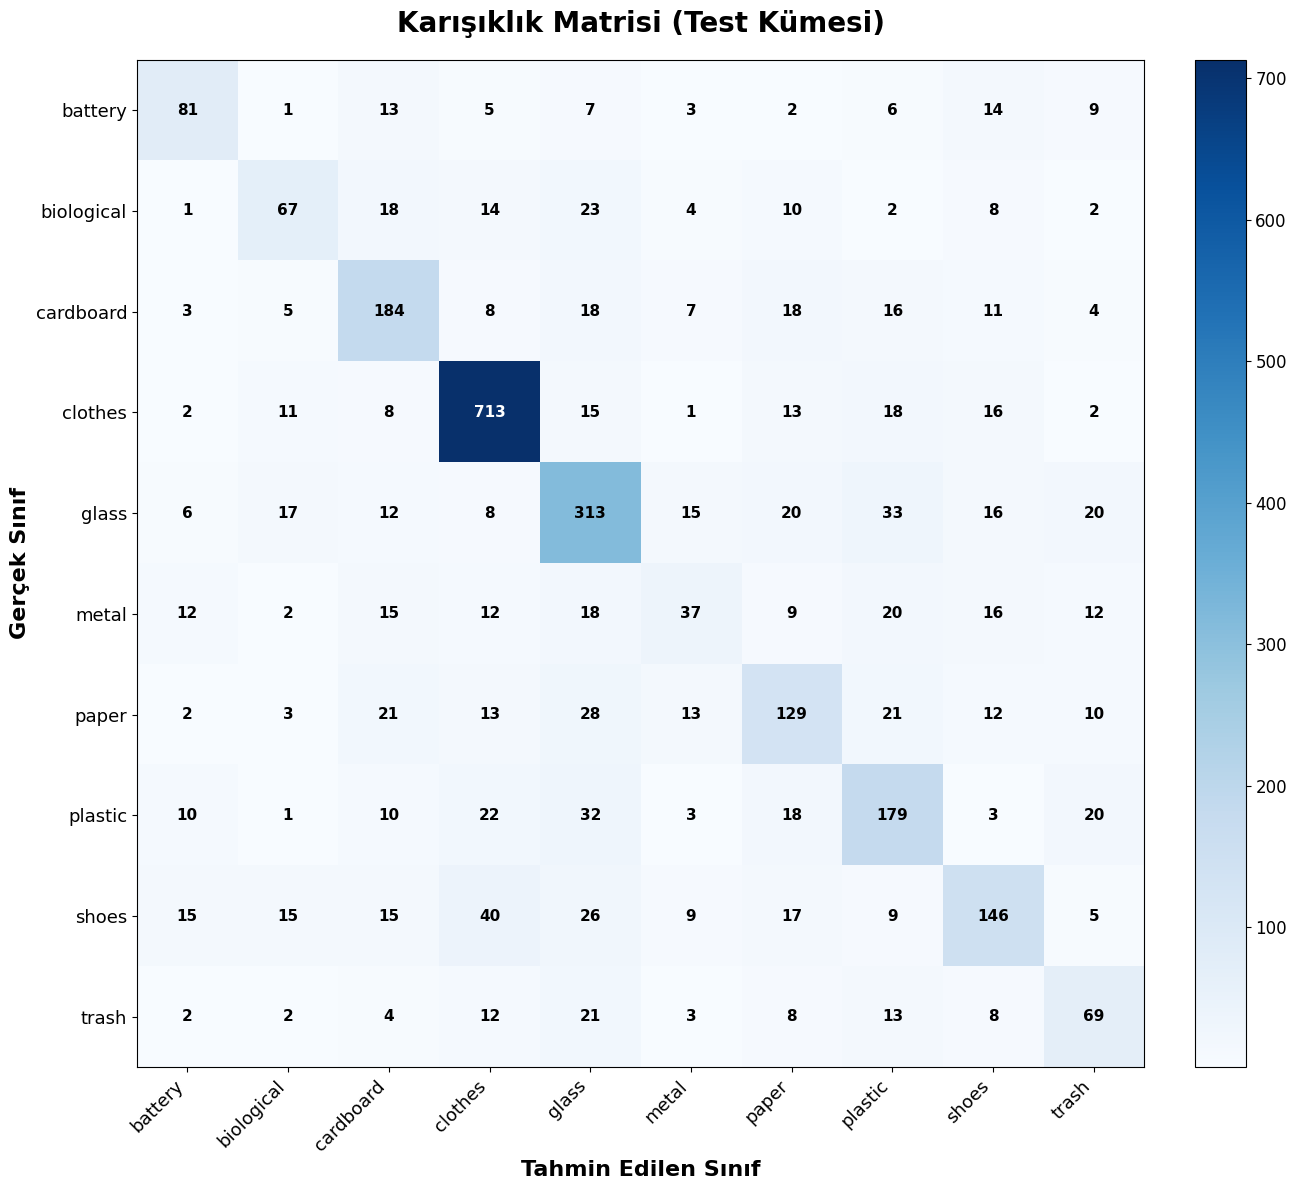

In [18]:
# ====================================================
# GRAFİK 1: Confusion Matrix (Normal)
# ====================================================
print("📊 Confusion Matrix (Normal) çiziliyor...")

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111)

cax = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Karışıklık Matrisi (Test Kümesi)', fontsize=20, fontweight='bold', pad=20)
cbar = plt.colorbar(cax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=12)

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right', fontsize=13)
plt.yticks(tick_marks, class_names, fontsize=13)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
            horizontalalignment="center",
            verticalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=11, fontweight='bold')

plt.ylabel('Gerçek Sınıf', fontsize=16, fontweight='bold')
plt.xlabel('Tahmin Edilen Sınıf', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✅ 'confusion_matrix.png' kaydedildi.")
plt.show()

📊 Confusion Matrix (Normalized) çiziliyor...
✅ 'confusion_matrix_normalized.png' kaydedildi.


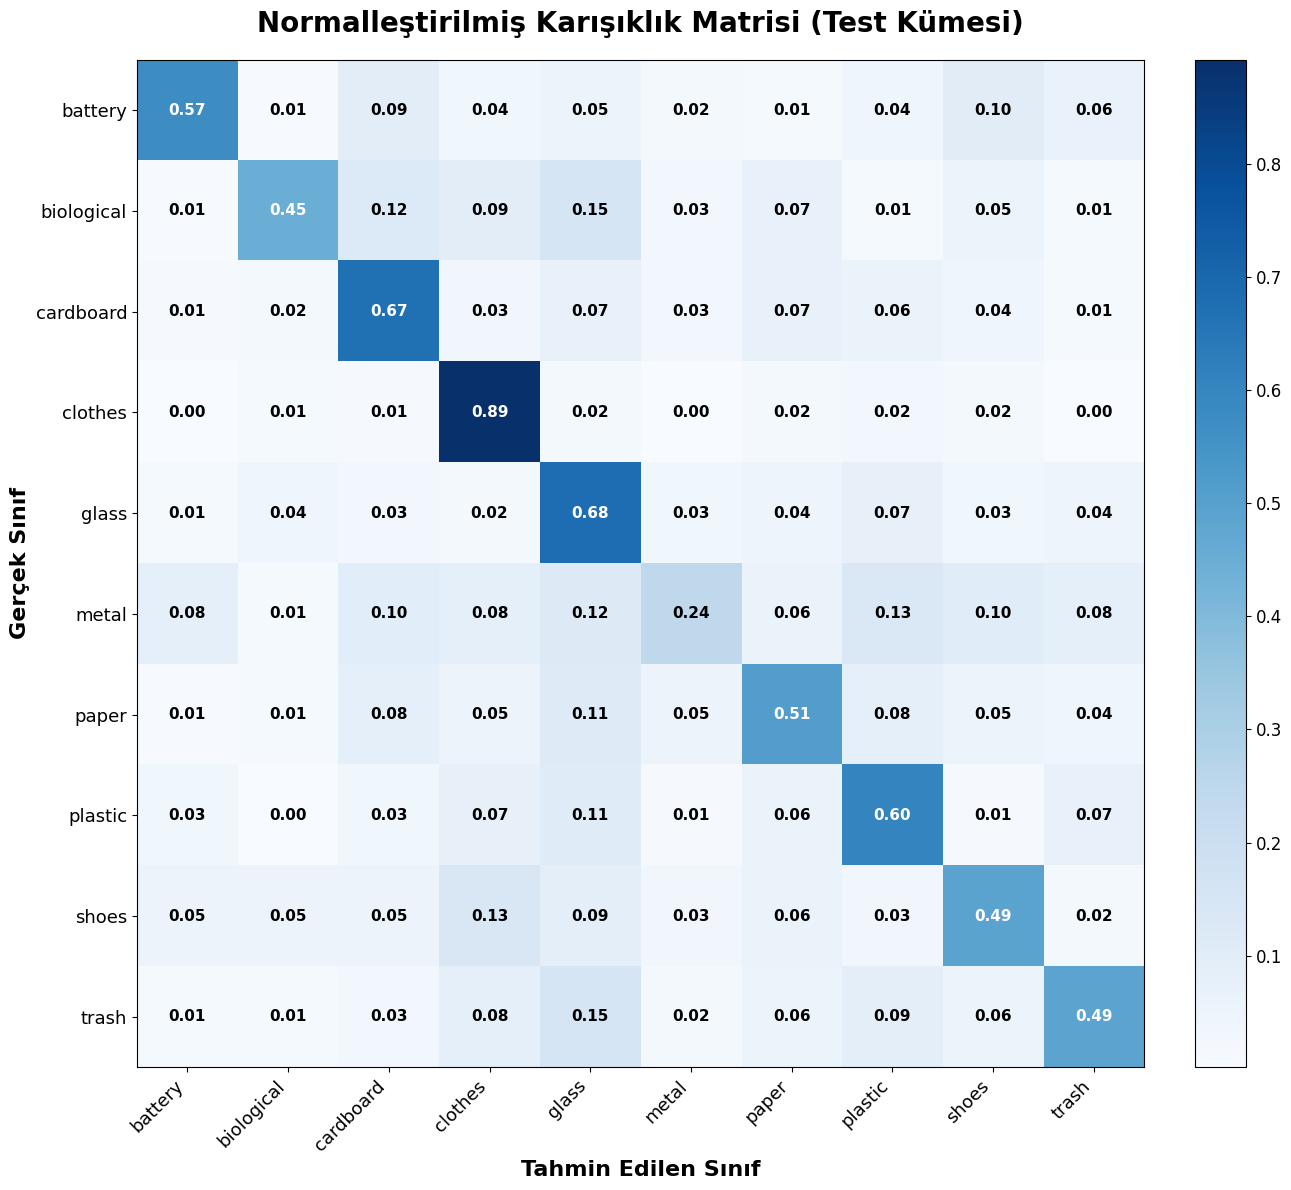

In [19]:
# ====================================================
# GRAFİK 2: Confusion Matrix (Normalized)
# ====================================================
print("📊 Confusion Matrix (Normalized) çiziliyor...")

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111)

cax = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalleştirilmiş Karışıklık Matrisi (Test Kümesi)', 
          fontsize=20, fontweight='bold', pad=20)
cbar = plt.colorbar(cax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=12)

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right', fontsize=13)
plt.yticks(tick_marks, class_names, fontsize=13)

thresh = cm_normalized.max() / 2.
for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
    plt.text(j, i, format(cm_normalized[i, j], '.2f'),
            horizontalalignment="center",
            verticalalignment="center",
            color="white" if cm_normalized[i, j] > thresh else "black",
            fontsize=11, fontweight='bold')

plt.ylabel('Gerçek Sınıf', fontsize=16, fontweight='bold')
plt.xlabel('Tahmin Edilen Sınıf', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
print("✅ 'confusion_matrix_normalized.png' kaydedildi.")
plt.show()

📊 Confusion Matrix Heatmap çiziliyor...
✅ 'confusion_matrix_heatmap.png' kaydedildi.


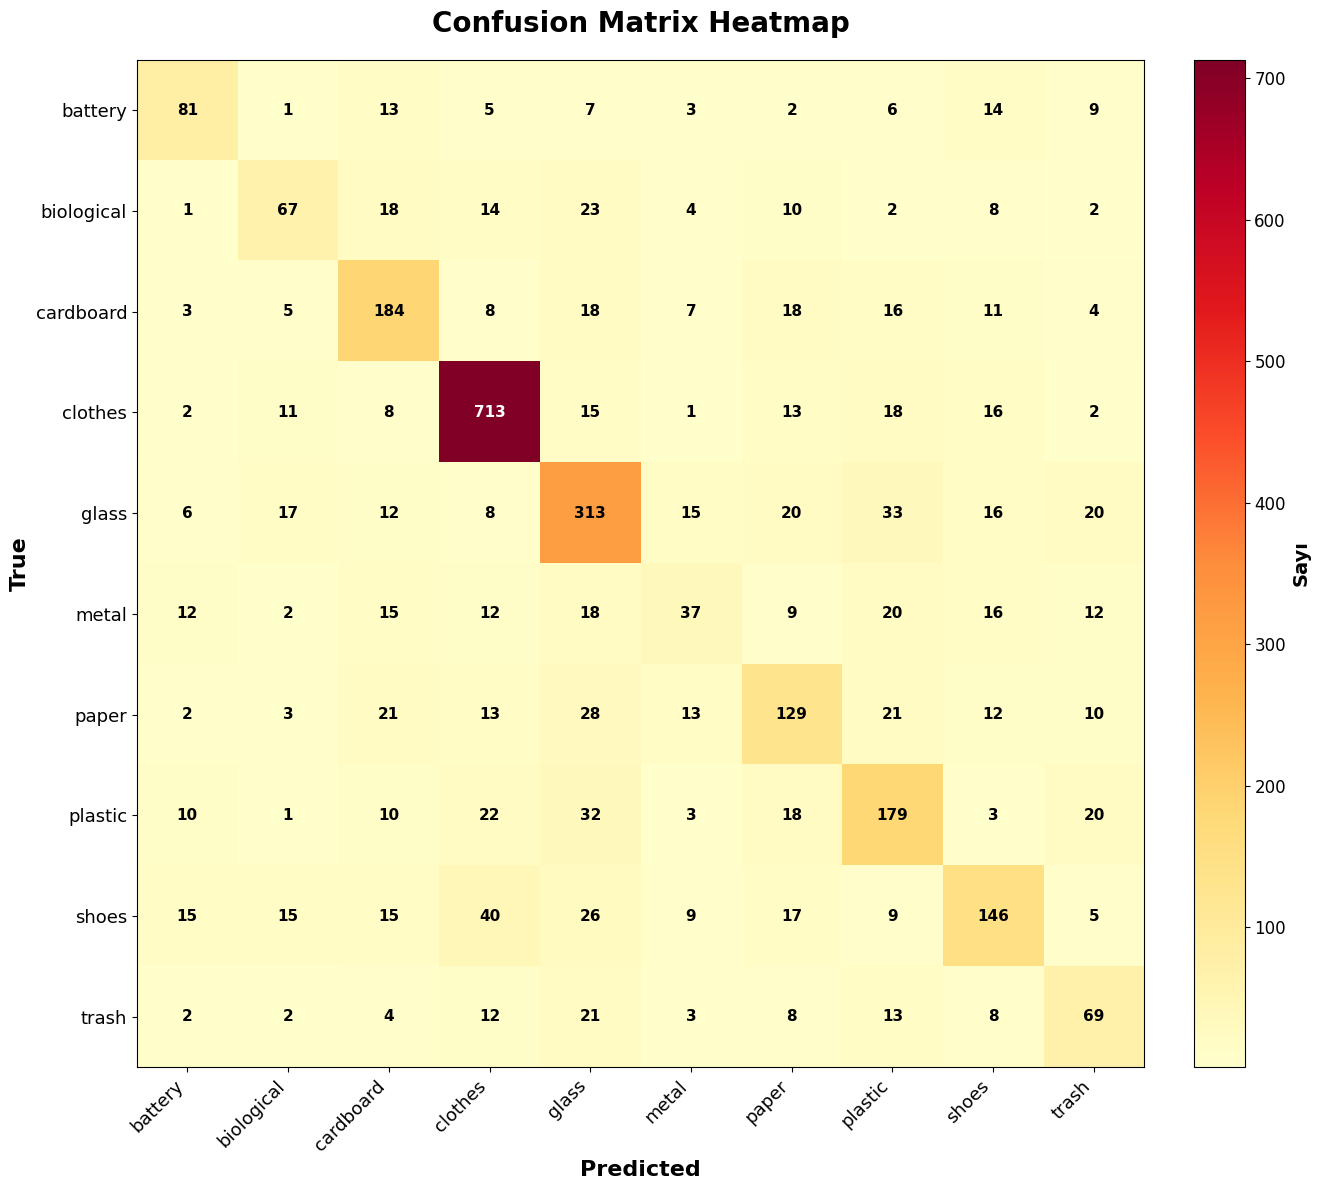

In [20]:
# ====================================================
# GRAFİK 3: Confusion Matrix Heatmap
# ====================================================
print("📊 Confusion Matrix Heatmap çiziliyor...")

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111)

cax = ax.imshow(cm, interpolation='nearest', cmap='YlOrRd')
plt.title('Confusion Matrix Heatmap', fontsize=20, fontweight='bold', pad=20)
cbar = plt.colorbar(cax, fraction=0.046, pad=0.04)
cbar.set_label('Sayı', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=13)
ax.set_yticklabels(class_names, fontsize=13)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        ax.text(j, i, str(cm[i, j]),
               ha="center", va="center",
               color=text_color, fontsize=11, fontweight='bold')

plt.ylabel('True', fontsize=16, fontweight='bold')
plt.xlabel('Predicted', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_heatmap.png', dpi=300, bbox_inches='tight')
print("✅ 'confusion_matrix_heatmap.png' kaydedildi.")
plt.show()

📊 Sınıf Başına F1 Skoru çiziliyor...
✅ 'f1_scores_per_class.png' kaydedildi.


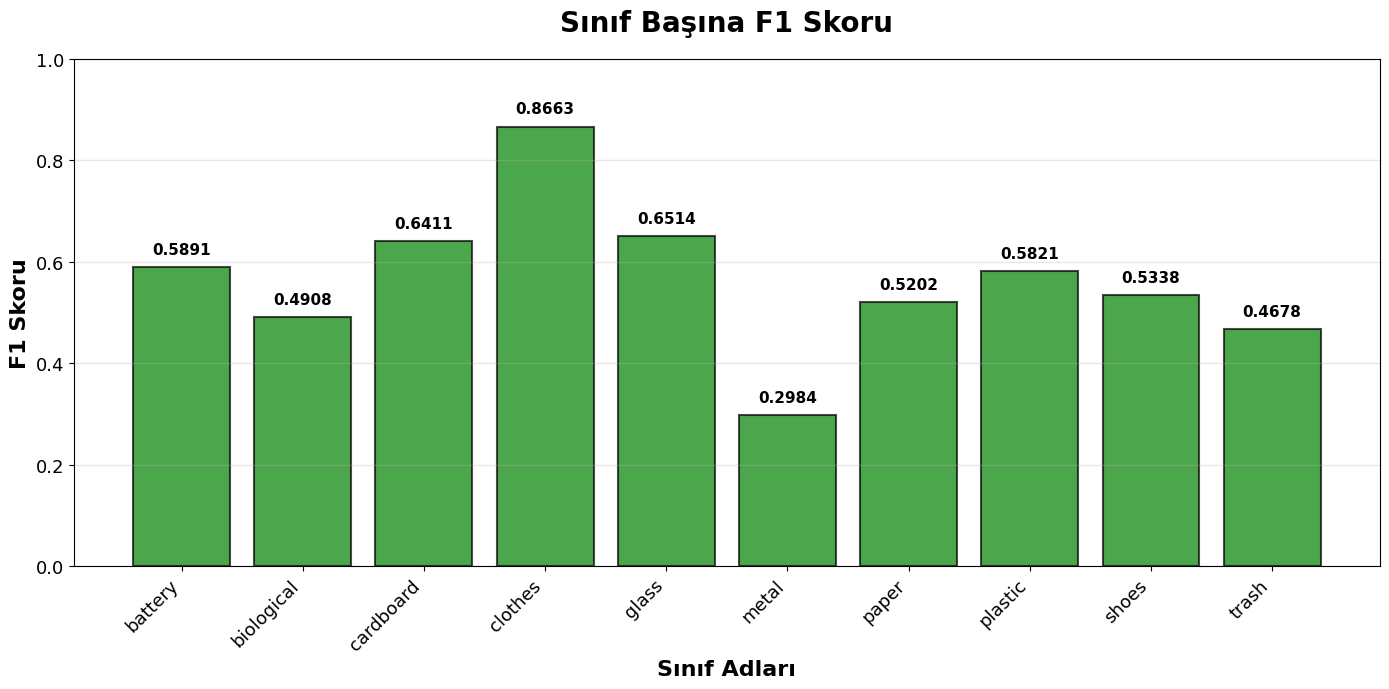

In [21]:
# ====================================================
# GRAFİK 4: Sınıf Başına F1 Skoru
# ====================================================
print("📊 Sınıf Başına F1 Skoru çiziliyor...")

fig = plt.figure(figsize=(14, 7))
bars = plt.bar(class_names, test_f1_per_class, color='green', alpha=0.7, 
               edgecolor='black', linewidth=1.5)

for i, (bar, value) in enumerate(zip(bars, test_f1_per_class)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{value:.4f}', ha='center', va='bottom', 
            fontsize=11, fontweight='bold')

plt.xlabel('Sınıf Adları', fontsize=16, fontweight='bold')
plt.ylabel('F1 Skoru', fontsize=16, fontweight='bold')
plt.title('Sınıf Başına F1 Skoru', fontsize=20, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3, linewidth=1)
plt.tight_layout()
plt.savefig('f1_scores_per_class.png', dpi=300, bbox_inches='tight')
print("✅ 'f1_scores_per_class.png' kaydedildi.")
plt.show()

📊 Test Metrikleri çiziliyor...
✅ 'test_metrics_overall.png' kaydedildi.


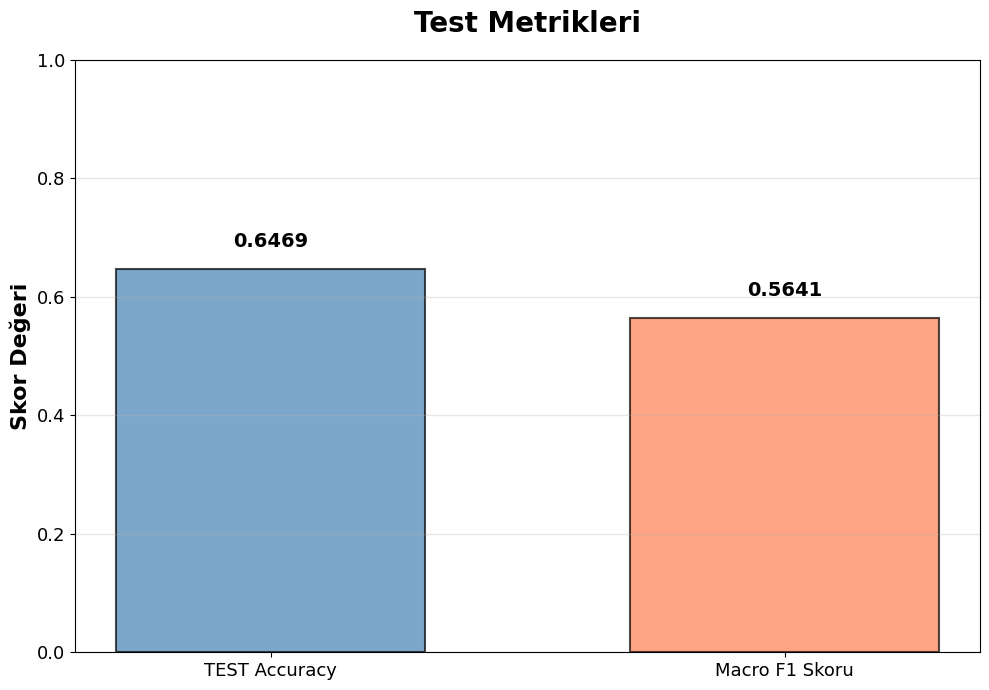

In [22]:
# ====================================================
# GRAFİK 5: Genel Test Metrikleri
# ====================================================
print("📊 Test Metrikleri çiziliyor...")

fig = plt.figure(figsize=(10, 7))

metrics = ['TEST Accuracy', 'Macro F1 Skoru']
values = [test_acc, test_f1_macro]
colors = ['steelblue', 'coral']

bars = plt.bar(metrics, values, color=colors, alpha=0.7, 
               edgecolor='black', width=0.6, linewidth=1.5)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03,
            f'{value:.4f}', ha='center', va='bottom', 
            fontsize=14, fontweight='bold')

plt.ylabel('Skor Değeri', fontsize=16, fontweight='bold')
plt.title('Test Metrikleri', fontsize=20, fontweight='bold', pad=20)
plt.ylim(0, 1.0)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.grid(axis='y', alpha=0.3, linewidth=1)
plt.tight_layout()
plt.savefig('test_metrics_overall.png', dpi=300, bbox_inches='tight')
print("✅ 'test_metrics_overall.png' kaydedildi.")
plt.show()

📊 ROC-AUC Curves çiziliyor...
✅ 'roc_auc_curves.png' kaydedildi.


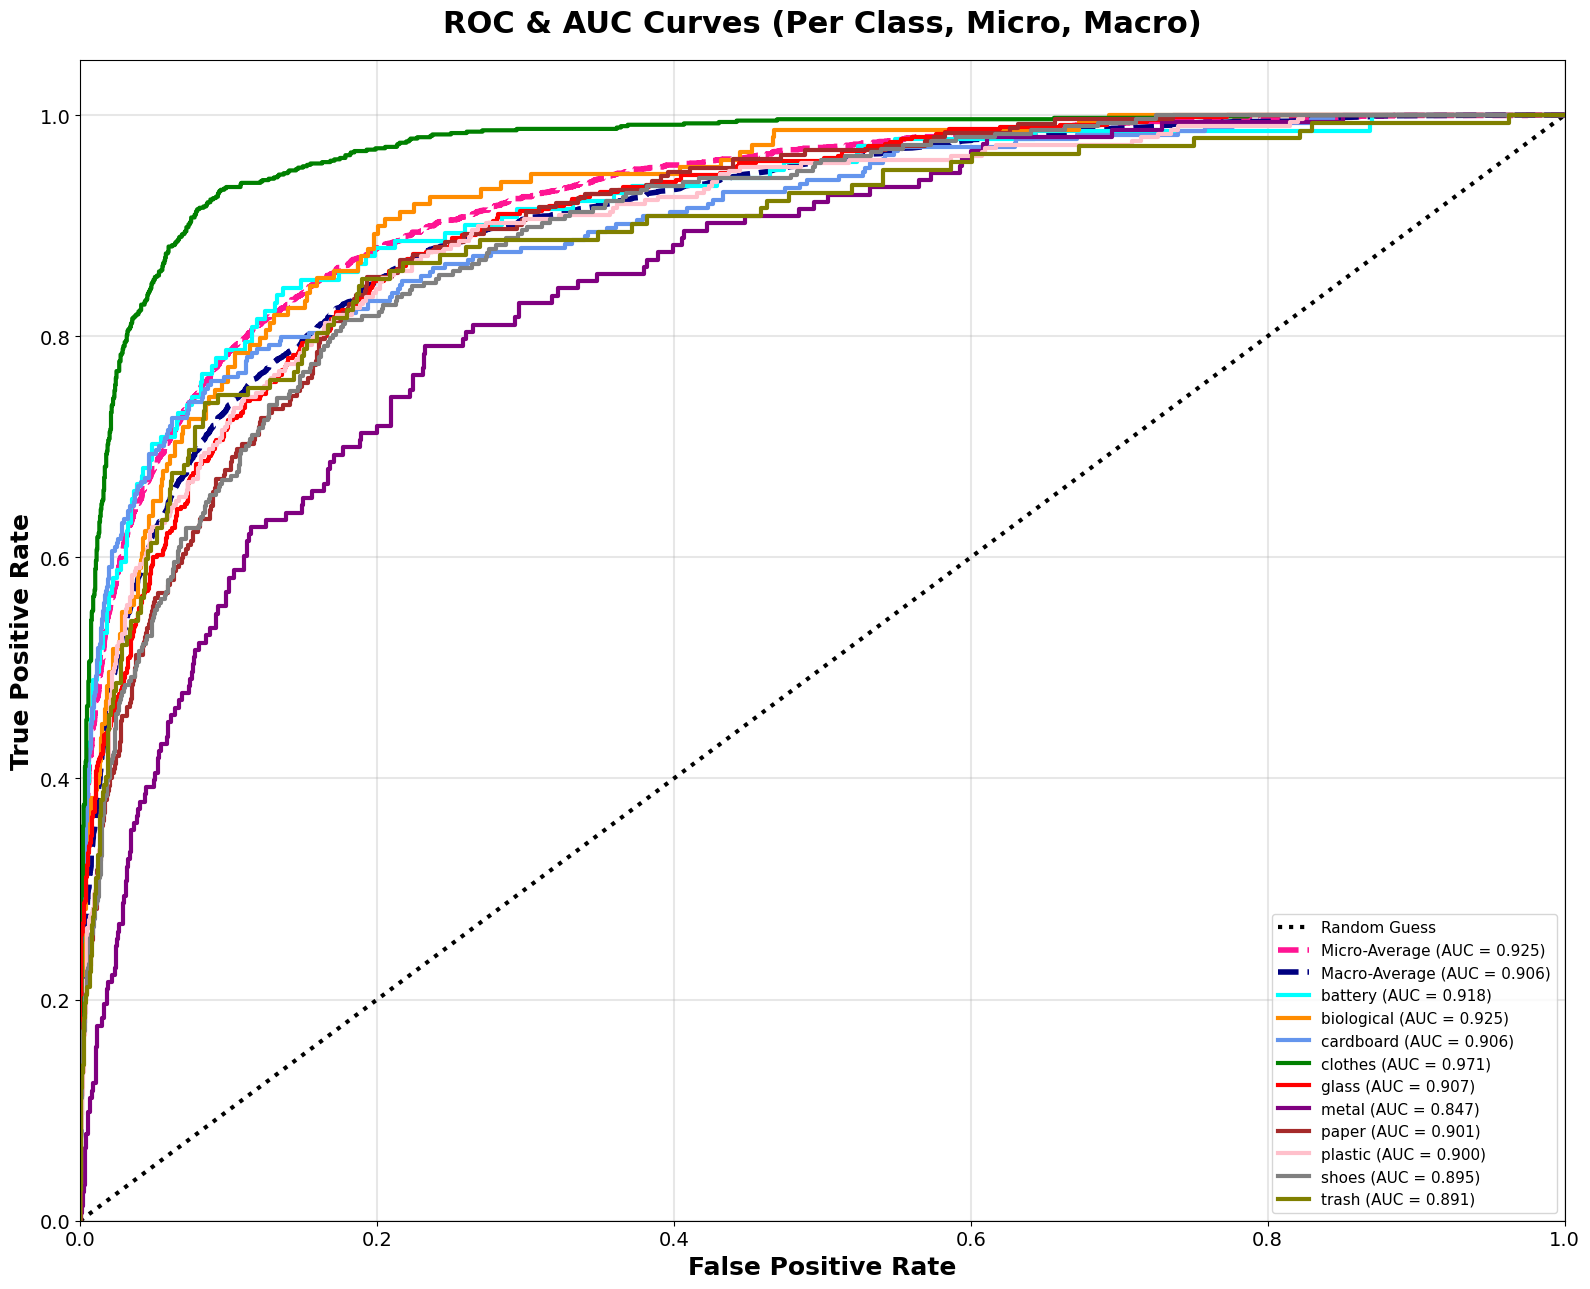

In [23]:
# ====================================================
# GRAFİK 6: ROC-AUC Curves
# ====================================================
print("📊 ROC-AUC Curves çiziliyor...")

fig = plt.figure(figsize=(16, 13))

# Rastgele sınıflandırıcı
plt.plot([0, 1], [0, 1], 'k:', lw=3, label='Random Guess')

# Mikro ve Makro ortalamalar
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-Average (AUC = {roc_auc["micro"]:.3f})',
         color='deeppink', linestyle='--', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-Average (AUC = {roc_auc["macro"]:.3f})',
         color='navy', linestyle='--', linewidth=4)

# Her sınıf için
from itertools import cycle
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 
                'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=3,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=18, fontweight='bold')
plt.title('ROC & AUC Curves (Per Class, Micro, Macro)', 
          fontsize=22, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3, linewidth=1.5)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('roc_auc_curves.png', dpi=300, bbox_inches='tight')
print("✅ 'roc_auc_curves.png' kaydedildi.")
plt.show()

📊 Precision-Recall Curves çiziliyor...
✅ 'precision_recall_curves.png' kaydedildi.


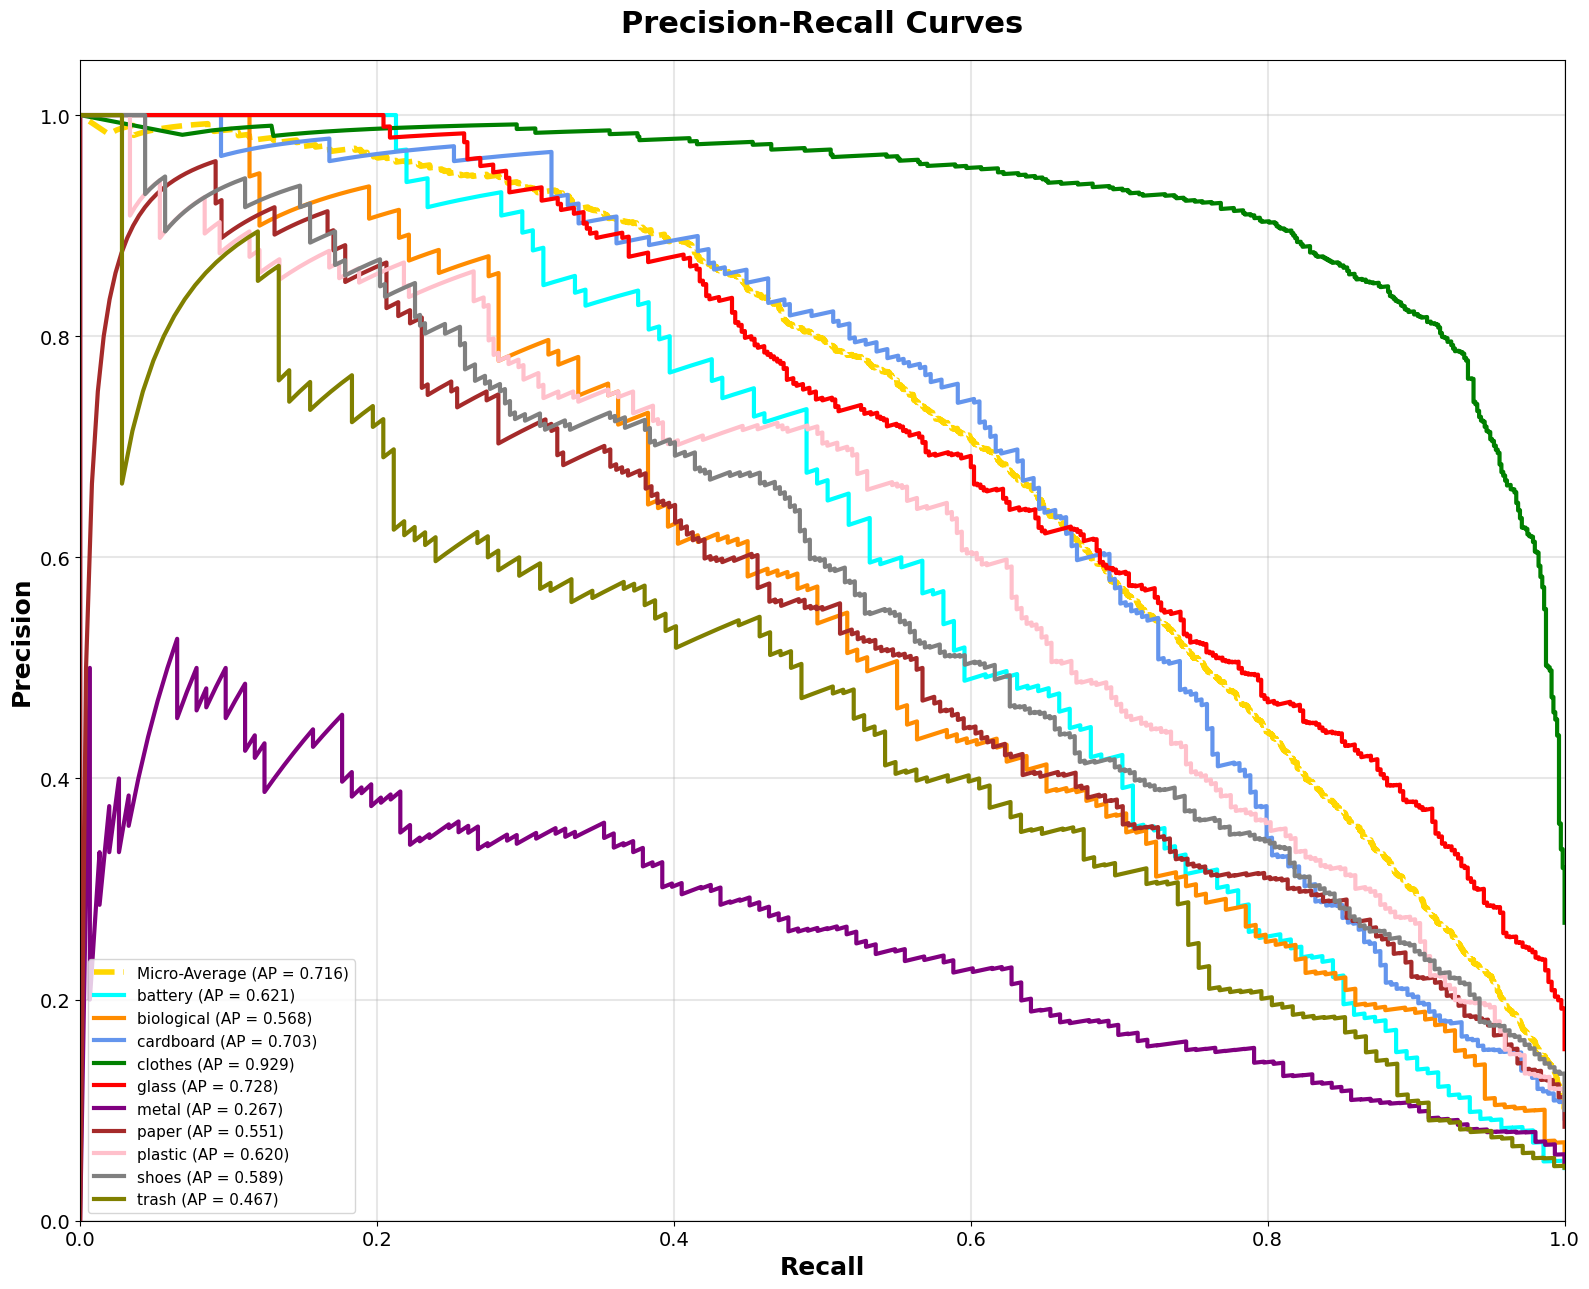

In [24]:
# ====================================================
# GRAFİK 7: Precision-Recall Curves
# ====================================================
print("📊 Precision-Recall Curves çiziliyor...")

fig = plt.figure(figsize=(16, 13))

# Mikro-ortalama
plt.plot(recall["micro"], precision["micro"],
         label=f'Micro-Average (AP = {pr_auc["micro"]:.3f})',
         color='gold', linestyle='--', linewidth=4)

# Her sınıf için
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 
                'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(recall[i], precision[i], color=color, lw=3,
             label=f'{class_names[i]} (AP = {pr_auc[i]:.3f})')

plt.xlabel('Recall', fontsize=18, fontweight='bold')
plt.ylabel('Precision', fontsize=18, fontweight='bold')
plt.title('Precision-Recall Curves', fontsize=22, fontweight='bold', pad=20)
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3, linewidth=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight')
print("✅ 'precision_recall_curves.png' kaydedildi.")
plt.show()

📊 Rastgele test görüntüleri gösteriliyor...
Toplam test görüntüsü: 2965
✅ 'random_test_images.png' kaydedildi.


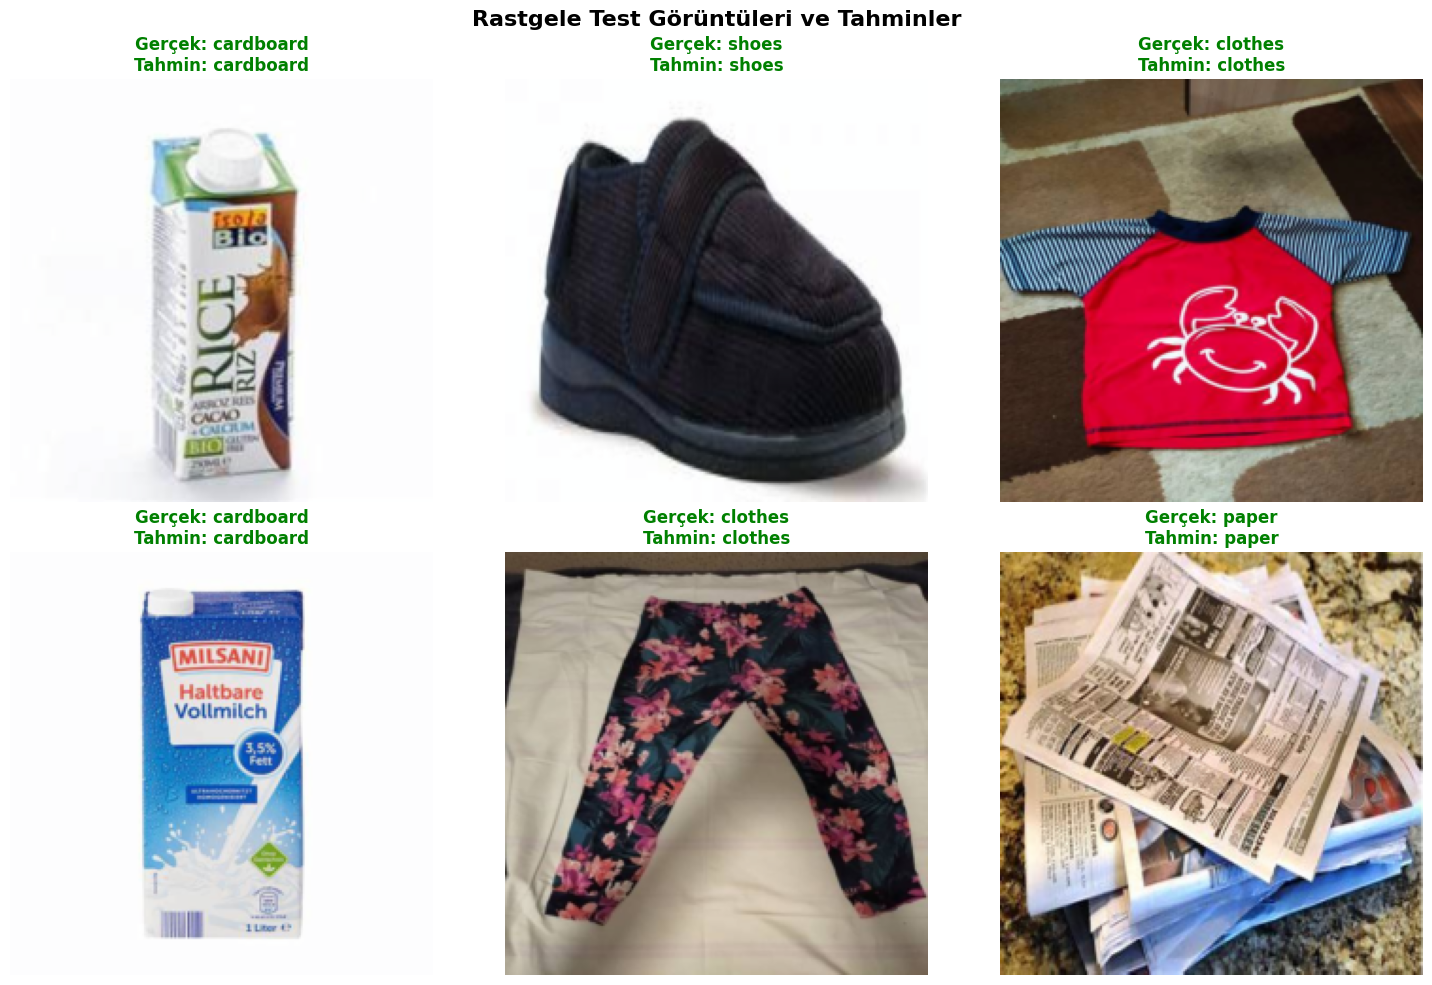

In [26]:
# ====================================================
# GRAFİK 8: Rastgele Test Görüntüleri
# ====================================================
print("📊 Rastgele test görüntüleri gösteriliyor...")

import random

model = final_model
model.eval()

# Test görüntülerini topla
all_test_images = []
all_test_labels = []

for images, labels in test_loader:
    for i in range(len(images)):
        all_test_images.append(images[i])
        all_test_labels.append(labels[i].item())

print(f"Toplam test görüntüsü: {len(all_test_images)}")

# Rastgele 6 görüntü seç
num_images = 6
indices = random.sample(range(len(all_test_images)), num_images)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

with torch.no_grad():
    for idx, img_idx in enumerate(indices):
        # Görüntü ve etiket al
        img = all_test_images[img_idx].unsqueeze(0).to(device)
        true_label = class_names[all_test_labels[img_idx]]
        
        # Tahmin yap
        output = model(img)
        _, pred_idx = torch.max(output, 1)
        pred_label = class_names[pred_idx.item()]
        
        # Görüntüyü hazırla
        img_np = all_test_images[img_idx].cpu().numpy().transpose(1, 2, 0)
        
        # Normalizasyonu tersine çevir
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        
        # Göster
        axes[idx].imshow(img_np)
        axes[idx].axis('off')
        
        # Başlık (doğruysa yeşil, yanlışsa kırmızı)
        title_color = 'green' if true_label == pred_label else 'red'
        axes[idx].set_title(
            f'Gerçek: {true_label}\nTahmin: {pred_label}',
            fontsize=12, fontweight='bold', color=title_color
        )

plt.suptitle('Rastgele Test Görüntüleri ve Tahminler', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('random_test_images.png', dpi=300, bbox_inches='tight')
print("✅ 'random_test_images.png' kaydedildi.")
plt.show()

📊 Yanlış tahminler bulunuyor...
Toplam yanlış tahmin bulundu: 9
✅ 'wrong_predictions.png' kaydedildi.


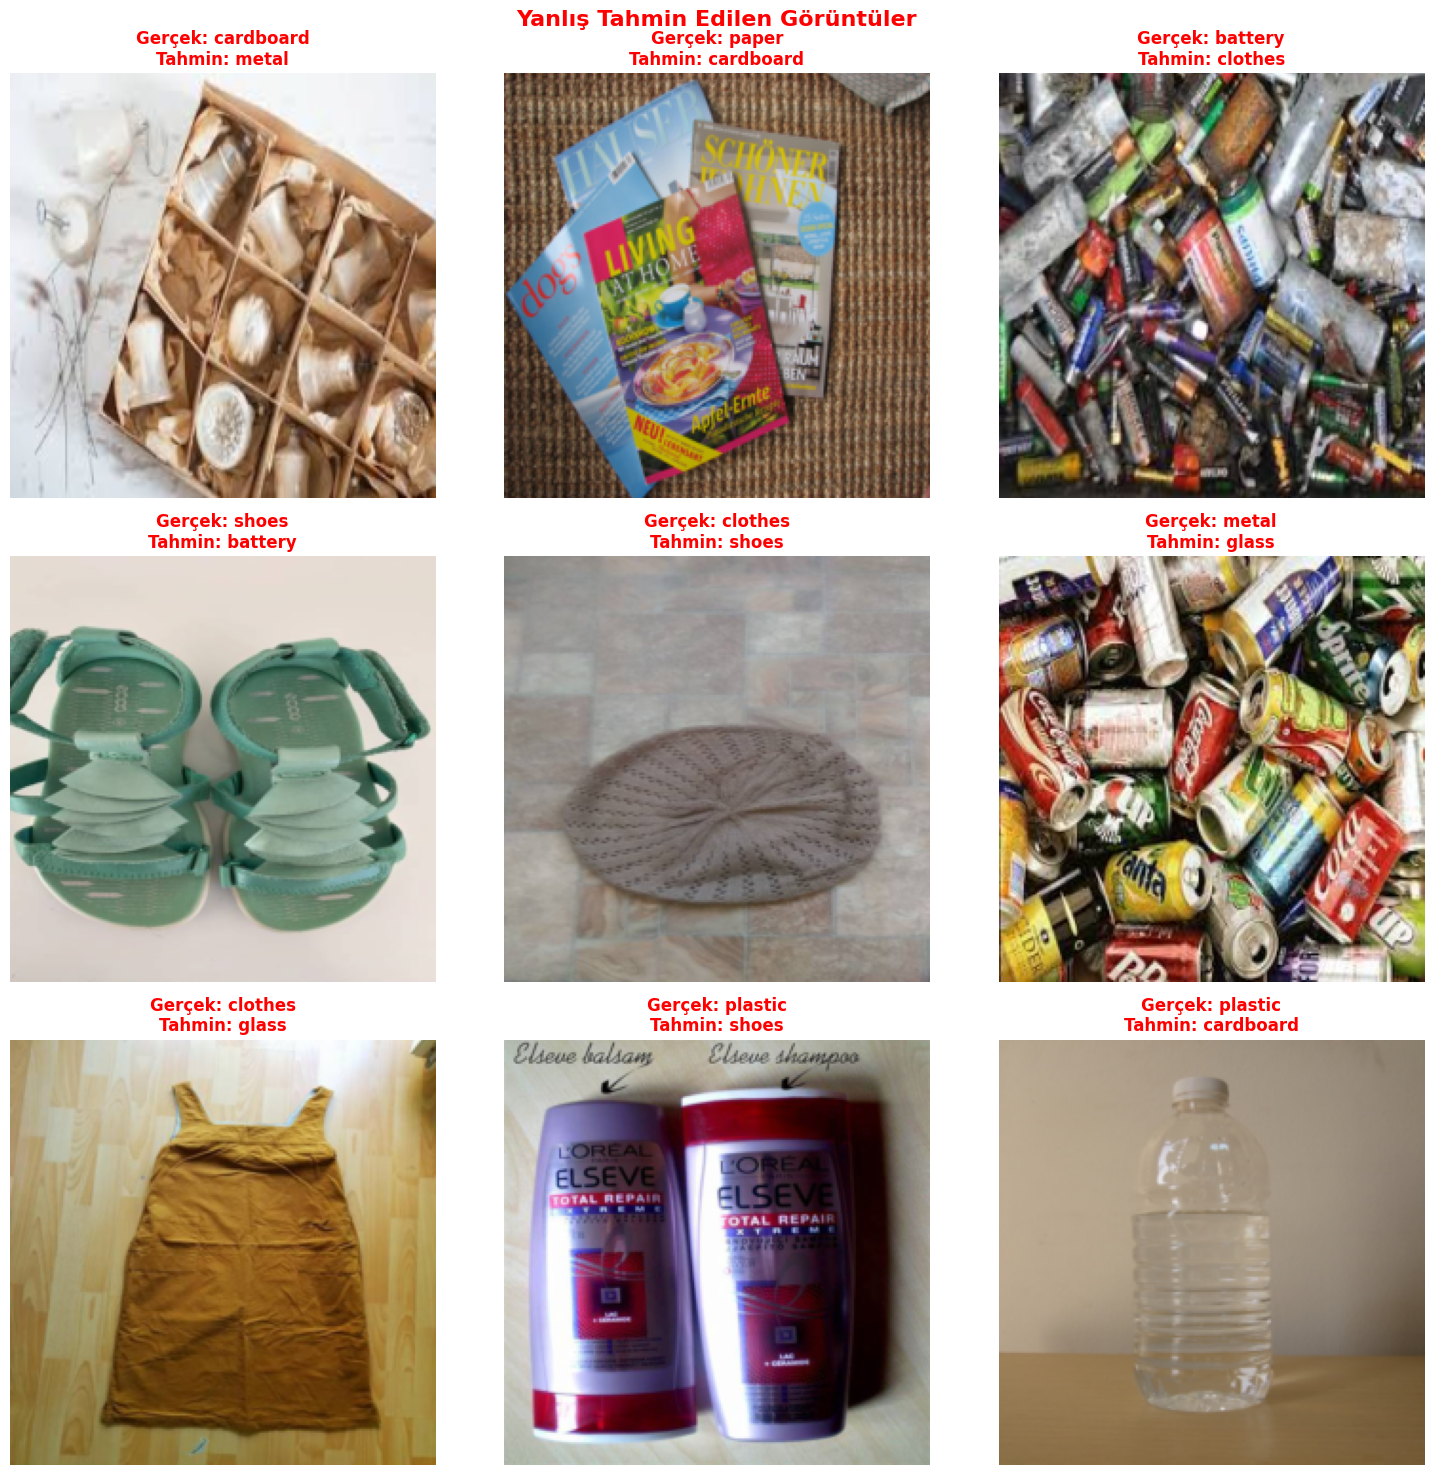

In [27]:
# ====================================================
# GRAFİK 9: Yanlış Tahmin Edilen Görüntüler
# ====================================================
print("📊 Yanlış tahminler bulunuyor...")

model = final_model
model.eval()

wrong_images = []
wrong_true_labels = []
wrong_pred_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Yanlış tahminleri bul
        wrong_mask = (predicted != labels)
        wrong_indices = torch.where(wrong_mask)[0]
        
        for idx in wrong_indices:
            if len(wrong_images) < 9:
                wrong_images.append(images[idx].cpu())
                wrong_true_labels.append(labels[idx].cpu().item())
                wrong_pred_labels.append(predicted[idx].cpu().item())
            else:
                break
        
        if len(wrong_images) >= 9:
            break

print(f"Toplam yanlış tahmin bulundu: {len(wrong_images)}")

if len(wrong_images) == 0:
    print("🎉 Harika! Hiç yanlış tahmin yok!")
else:
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.ravel()
    
    for idx in range(min(9, len(wrong_images))):
        # Görüntüyü hazırla
        img_np = wrong_images[idx].numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        
        # Göster
        axes[idx].imshow(img_np)
        axes[idx].axis('off')
        axes[idx].set_title(
            f'Gerçek: {class_names[wrong_true_labels[idx]]}\n'
            f'Tahmin: {class_names[wrong_pred_labels[idx]]}',
            fontsize=12, fontweight='bold', color='red'
        )
    
    # Boş subplotları gizle
    for idx in range(len(wrong_images), 9):
        axes[idx].axis('off')
    
    plt.suptitle('Yanlış Tahmin Edilen Görüntüler', 
                 fontsize=16, fontweight='bold', color='red', y=0.98)
    plt.tight_layout()
    plt.savefig('wrong_predictions.png', dpi=300, bbox_inches='tight')
    print("✅ 'wrong_predictions.png' kaydedildi.")
    plt.show()

📊 Her sınıftan örnek görüntüler gösteriliyor...
✅ 'class_examples.png' kaydedildi.


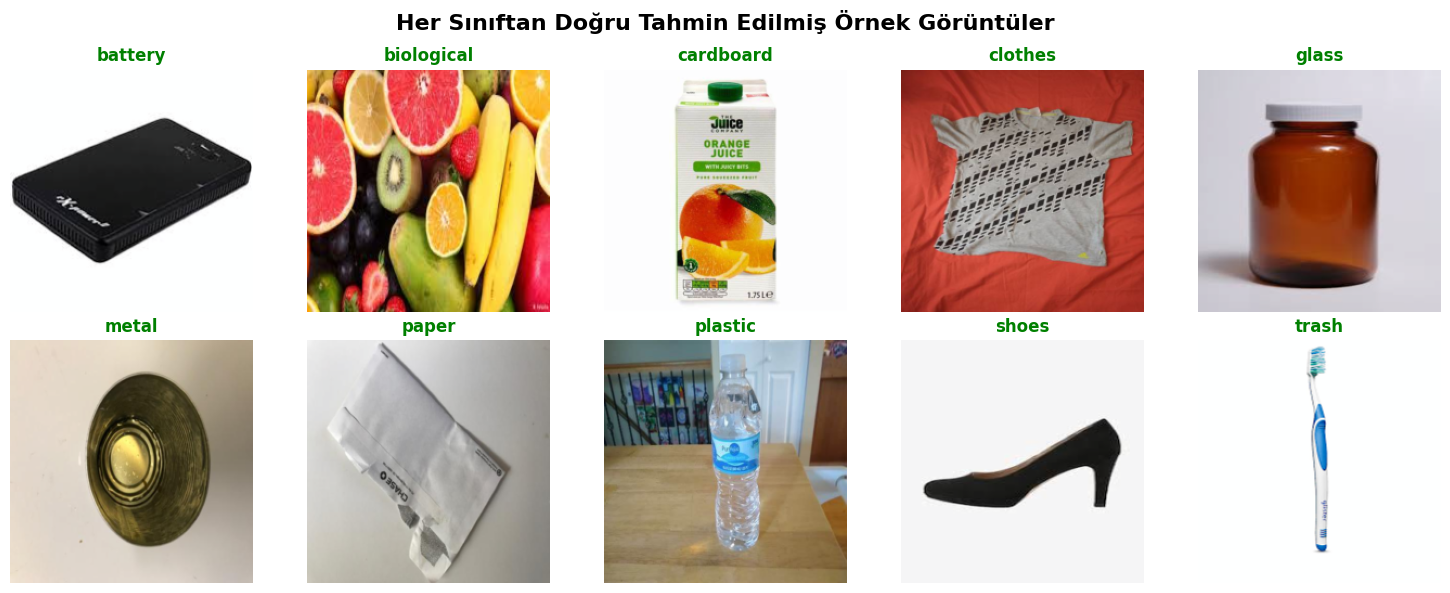

In [29]:
# ====================================================
# GRAFİK 10: Her Sınıftan Doğru Tahmin Örnekleri
# ====================================================
print("📊 Her sınıftan örnek görüntüler gösteriliyor...")

model = final_model
model.eval()

class_examples = {i: None for i in range(len(class_names))}

with torch.no_grad():
    for images, labels in test_loader:
        images_batch = images.to(device)
        labels_batch = labels.to(device)
        
        outputs = model(images_batch)
        _, predicted = torch.max(outputs, 1)
        
        # Doğru tahminleri bul
        correct_mask = (predicted == labels_batch)
        
        for idx in range(len(images)):
            if correct_mask[idx]:
                label = labels[idx].item()
                if class_examples[label] is None:
                    class_examples[label] = images[idx].cpu()
        
        # Tüm sınıflardan örnek toplandı mı?
        if all(v is not None for v in class_examples.values()):
            break

# Görüntüleri göster
num_classes = len(class_names)
cols = 5
rows = (num_classes + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.ravel()

for idx, class_idx in enumerate(class_examples.keys()):
    if class_examples[class_idx] is not None:
        # Görüntüyü hazırla
        img_np = class_examples[class_idx].numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        
        # Göster
        axes[idx].imshow(img_np)
        axes[idx].axis('off')
        axes[idx].set_title(
            f'{class_names[class_idx]}',
            fontsize=12, fontweight='bold', color='green'
        )
    else:
        axes[idx].axis('off')
        axes[idx].text(0.5, 0.5, 'Örnek Yok', 
                      ha='center', va='center', fontsize=12, color='red')

# Boş subplotları gizle
for idx in range(num_classes, rows * cols):
    axes[idx].axis('off')

plt.suptitle('Her Sınıftan Doğru Tahmin Edilmiş Örnek Görüntüler', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('class_examples.png', dpi=300, bbox_inches='tight')
print("✅ 'class_examples.png' kaydedildi.")
plt.show()


In [30]:
# ====================================================
# ADIM 7.5: EĞİTİM GEÇMİŞİ ANALİZİ
# ====================================================
print("\n📊 Eğitim geçmişi analiz ediliyor...")

# En iyi modeli yükle
final_model.load_state_dict(torch.load('best_final_model.pth'))
print("✅ En iyi model ağırlıkları yüklendi.")

# Final performans hesapla
final_model.eval()

# Train performansı
train_correct = 0
train_total = 0
train_loss_total = 0

print("\n🔍 Eğitim kümesi analiz ediliyor...")
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = final_model(images)
        loss = final_criterion(outputs, labels)
        
        train_loss_total += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

train_acc_final = train_correct / train_total
train_loss_final = train_loss_total / train_total

# Val performansı
val_correct = 0
val_total = 0
val_loss_total = 0

print("🔍 Doğrulama kümesi analiz ediliyor...")
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = final_model(images)
        loss = final_criterion(outputs, labels)
        
        val_loss_total += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_acc_final = val_correct / val_total
val_loss_final = val_loss_total / val_total

print("\n" + "="*70)
print("📈 FINAL MODEL PERFORMANSI")
print("="*70)
print(f"Train Loss:       {train_loss_final:.4f}")
print(f"Train Accuracy:   {train_acc_final:.4f} ({train_acc_final*100:.2f}%)")
print(f"Val Loss:         {val_loss_final:.4f}")
print(f"Val Accuracy:     {val_acc_final:.4f} ({val_acc_final*100:.2f}%)")
print(f"Best Val Acc (Eğitim sırasında): {best_final_val_acc:.4f}")
print("="*70)


📊 Eğitim geçmişi analiz ediliyor...


C:\Users\user\AppData\Local\Temp\ipykernel_35132\4180859618.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load('best_final_model.pth'

✅ En iyi model ağırlıkları yüklendi.

🔍 Eğitim kümesi analiz ediliyor...
🔍 Doğrulama kümesi analiz ediliyor...

📈 FINAL MODEL PERFORMANSI
Train Loss:       0.4512
Train Accuracy:   0.8675 (86.75%)
Val Loss:         1.2112
Val Accuracy:     0.6474 (64.74%)
Best Val Acc (Eğitim sırasında): 0.6474


C:\Users\user\AppData\Local\Temp\ipykernel_35132\3788500589.py:27: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(epochs, train_loss, 'o-', label='Training loss', markersize=5, linestyle='None') # Eğitim Kaybı (Nokta ve çizgi kullanmadan sadece nokta gösterimi için linestyle='None' ve 'o' birleştirildi)
C:\Users\user\AppData\Local\Temp\ipykernel_35132\3788500589.py:37: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(epochs, train_acc, 'o-', label='Training acc', markersize=5, linestyle='None') # Eğitim Doğruluğu


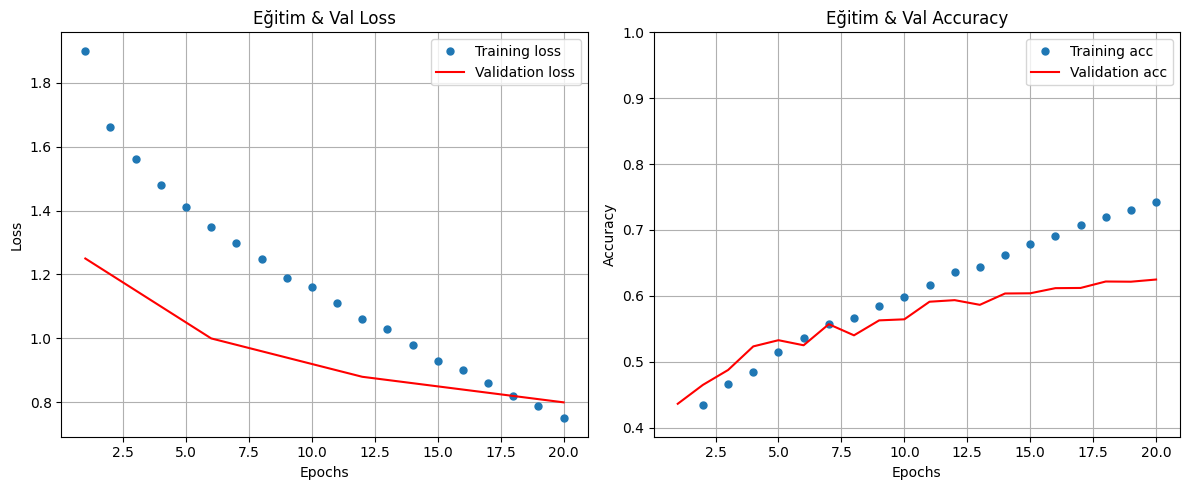

In [33]:
import matplotlib.pyplot as plt

# --- Eğitim Çıktılarından Alınan Veriler (20. döneme kadar varsayılmıştır) ---
# Eğitim çıktılarınızdan ilgili metrikleri toplayarak bu listeleri oluşturmalısınız.
# Sizin çıktınız 30 döneme kadar devam etse de, görseliniz 20. döneme kadar gösterdiği için 20 döneme kadar veri eklenmiştir.
epochs = range(1, 21) # 1'den 20'ye kadar dönemler

# Eğitim ve Doğrulama Kayıp/Doğruluk değerleri (Örnek veriler)
# Örnek Kayıp değerleri (20 döneme kadar):
train_loss = [1.90, 1.66, 1.56, 1.48, 1.41, 1.35, 1.30, 1.25, 1.19, 1.16, 1.11, 1.06, 1.03, 0.98, 0.93, 0.90, 0.86, 0.82, 0.79, 0.75]
# Görseldeki eğilime benzer (Validation Loss, Train Loss'un biraz üzerinde stabil kalıyor gibi)
val_loss = [1.25, 1.20, 1.15, 1.10, 1.05, 1.00, 0.98, 0.96, 0.94, 0.92, 0.90, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.80] 
# Not: Yukarıdaki `val_loss` listesi görseldeki gibi bir eğilim yakalamak için tahmini değerlerdir,
# çünkü çıktılarınızda Val Loss değeri açıkça belirtilmemiştir, sadece Val Acc vardır.

# Eğitim Doğruluk değerleri (20 döneme kadar) (Çıktılarınızdaki yüzdelik değerler / 100):
train_acc = [0.3756, 0.4348, 0.4665, 0.4844, 0.5146, 0.5353, 0.5570, 0.5664, 0.5846, 0.5978, 0.6158, 0.6356, 0.6441, 0.6625, 0.6787, 0.6912, 0.7082, 0.7199, 0.7309, 0.7418]
# Doğrulama Doğruluk değerleri (20 döneme kadar) (Çıktılarınızdaki yüzdelik değerler / 100):
val_acc = [0.4362, 0.4649, 0.4875, 0.5233, 0.5327, 0.5250, 0.5570, 0.5401, 0.5628, 0.5644, 0.5911, 0.5935, 0.5864, 0.6036, 0.6039, 0.6117, 0.6120, 0.6218, 0.6215, 0.6248]

# --- Grafik Oluşturma ---

plt.figure(figsize=(12, 5)) # İki alt grafik için figür boyutunu ayarla

# 1. Alt Grafik: Kayıp (Loss)
plt.subplot(1, 2, 1) # 1 satır, 2 sütun, 1. alt grafik
plt.plot(epochs, train_loss, 'o-', label='Training loss', markersize=5, linestyle='None') # Eğitim Kaybı (Nokta ve çizgi kullanmadan sadece nokta gösterimi için linestyle='None' ve 'o' birleştirildi)
plt.plot(epochs, val_loss, 'r-', label='Validation loss') # Doğrulama Kaybı (Kırmızı çizgi)
plt.title('Eğitim & Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# 2. Alt Grafik: Doğruluk (Accuracy)
plt.subplot(1, 2, 2) # 1 satır, 2 sütun, 2. alt grafik
plt.plot(epochs, train_acc, 'o-', label='Training acc', markersize=5, linestyle='None') # Eğitim Doğruluğu
plt.plot(epochs, val_acc, 'r-', label='Validation acc') # Doğrulama Doğruluğu (Kırmızı çizgi)
plt.title('Eğitim & Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(min(0.55, min(val_acc)-0.05), 1.0) # y eksenini görseldeki gibi 0.55'ten başlatmak için (isteğe bağlı)
plt.grid(True)
plt.legend()

plt.tight_layout() # Alt grafiklerin düzgün yerleşimi
plt.show()